> Notebook com o treinamento dos modelos de ML para a classificação do label vivo_ano3.

---

1) excluir os casos de pele não melanoma (CID-O CID44 com as morfologias entre 80101 e 81103); ok

2) não utilizar as datas de recidiva (na ficha de seguimento há sobreposição); ok

3) a variável Cidade de residência (transformada em  RRAS - Rede Regional de Atenção à Saúde) relacionada com RRAS de atendimento (o valor 99 é ignorado);

4) Na questão de predição do óbito, sugiro que o comportamento 1 e 2 não sejam interessantes para a análise. Ao se observar a coluna MORFO o último dígito 1, 2 ou 3 faz referencia ao comportamento do tumor, por exemplo, 80503 = ductal invasivo. Os últimos dígitos 1 são incerto se benigno ou limítrofe e 2 carcinoma in situ.
Minha sugestão é gerar uma variável chamada comportamento e deixar só o comportamento 3 para certas análises; ok

5) trabalhar com o ano do diagnóstico agrupado é uma boa opção. O câncer não sofre mudanças abruptas ao longo do tempo e controlar por períodos de diagnóstico pode ser mais vantajoso (2000 - 2004; 2005 - 2009; 2010 - 2015). ok

6) não me recordo se os estadiamentos X e Y foram retirados, mas não devem ser trabalhados; ok

7) EC e ECGRUP dizem quase a mesma coisa. Talvez verificar o melhor preditor e usar para o modelo; ok

8) quanto a variável metástase e recidiva a distancia, deveriam estar preenchidas de forma homogênea, assim sugiro usar as informações de recidiva à distância;

9) o tempo entre o diagnóstico e o tratamento ou consulta e o tratamento devem ser recalculados (foi refeito, eu me recordo) e retirados das análise aqueles que não tiveram a possibilidade de serem tratados; ok

10) nesta base, a última coluna está preenchida com as habilitações para o tratamento CACON e UNACON. ok

# **Libraries**

Import of all libraries used in the project. 

In [ ]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle # Save models
seed = 10 # seed for the random state

In [ ]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

In [ ]:
# Classification
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn import tree

# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

## **General**

In [ ]:
def read_csv(path):
  """"Read csv files

  :param path str: path to the csv file.

  :return: dataframe from the csv file.
  :rtype: pd.DataFrame
  """

  df = pd.read_csv(path, dtype={'M': str})
  print(df.shape)

  return df

In [ ]:
def save_csv(df, path):
  """Save csv files

  :param df pd.DataFrame: dataframe to be saved.
  :param path str: path to save the csv file.

  :return: no value
  :rtype: none
  """

  df.to_csv(path, encoding='utf-8', index=False)
  print('CSV file saved successfully!')

In [ ]:
def get_dates_diff(df, dates_list):
  """Get the difference, in days, between columns with dates

  :param df pd.DataFrame: DataFrame to get the dates difference.
  :param dates_list list: list with the name of date columns.

  :return: DataFrame with dates difference in nine new columns 
  :rtype: pd.DataFrame
  """
  
  df_aux = df.copy()
  
  df_aux.dropna(subset=['DTTRAT','DTULTINFO'], inplace=True)
  
  for c in dates_list:
    if c in ['DTTRAT','DTULTINFO','DTRECIDIVA']: # Has a different date format 
      fmt = '%Y-%m-%d %H:%M:%S'
    else:
      fmt = '%Y-%m-%d'
    df_aux[c] = pd.to_datetime(df_aux[c], format=fmt)

  df_aux['delta_t1'] = (df_aux.DTDIAG - df_aux.DTCONSULT).dt.days
  df_aux['delta_t2'] = (df_aux.DTTRAT - df_aux.DTDIAG).dt.days
  df_aux['delta_t3'] = (df_aux.DTTRAT - df_aux.DTCONSULT).dt.days

  df_aux['delta_t4'] = (df_aux.DTRECIDIVA - df_aux.DTCONSULT).dt.days
  df_aux['delta_t5'] = (df_aux.DTRECIDIVA - df_aux.DTDIAG).dt.days
  df_aux['delta_t6'] = (df_aux.DTRECIDIVA - df_aux.DTTRAT).dt.days

  df_aux['delta_t7'] = (df_aux.DTULTINFO - df_aux.DTCONSULT).dt.days
  df_aux['delta_t8'] = (df_aux.DTULTINFO - df_aux.DTDIAG).dt.days
  df_aux['delta_t9'] = (df_aux.DTULTINFO - df_aux.DTTRAT).dt.days

  return df_aux

In [ ]:
def get_labels(df):
  """Create death labels acording to the last information year.

  :param df pd.DataFrame: dataframe to be processed.

  :return: DataFrame with the new labels
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  df_aux['obito_geral'] = 0
  df_aux['obito_cancer'] = 0

  df_aux['vivo_ano1'] = 0
  df_aux['vivo_ano3'] = 0
  df_aux['vivo_ano5'] = 0 
  
  df_aux.loc[df_aux.ULTINFO > 2, 'obito_geral'] = 1

  df_aux.loc[df_aux.ULTINFO == 3, 'obito_cancer'] = 1

  df_aux.loc[df_aux.delta_t8 > 365, 'vivo_ano1'] = 1
  df_aux.loc[df_aux.delta_t8 > 3*365, 'vivo_ano3'] = 1
  df_aux.loc[df_aux.delta_t8 > 5*365, 'vivo_ano5'] = 1

  return df_aux

In [ ]:
def get_label_rec(df):
  """Create the labels analyzing whether there was recurrence.
  
  :param df pd.DataFrame: dataframe to be processed.

  :return: DataFrame with the new labels
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  df_aux['ob_com_rec'] = 0
  df_aux['ob_sem_rec'] = 0
  df_aux['vivo_com_rec'] = 0
  df_aux['vivo_sem_rec'] = 0

  df_aux.loc[(df_aux.obito_geral == 1) & (df_aux.RECNENHUM == 1), 'ob_sem_rec'] = 1
  df_aux.loc[(df_aux.obito_geral == 1) & (df_aux.RECNENHUM == 0), 'ob_com_rec'] = 1
  df_aux.loc[(df_aux.obito_geral == 0) & (df_aux.RECNENHUM == 1), 'vivo_sem_rec'] = 1
  df_aux.loc[(df_aux.obito_geral == 0) & (df_aux.RECNENHUM == 0), 'vivo_com_rec'] = 1

  return df_aux

## **Models**

In [ ]:
def variables_preprocessing(df):
  """Do some preprocessing on the DataFrame like strings splits, fill NaN values,
     replace values and drop some columns.

  :param df pd.DataFrame: DataFrame to be preprocessed.

  :return: DataFrame after be preprocessed and get some columns removed
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()
  no_info = '**Sem informação**'

  # Excluding ECGRUP with X and Y values
  df_aux = df_aux[~df_aux.ECGRUP.isin(['X','Y'])]

  # Excluding C44 topographies (with morphologies between 80101 and 81103)
  df_aux = df_aux[~((df_aux.TOPOGRUP == 'C44') & (df_aux.MORFO >= 80101) & (df_aux.MORFO <= 81103))]

  # REGISTRADO
  df_aux.REGISTRADO.fillna(99, inplace=True)

  # DRS
  DRS_expand = df_aux.DRS.str.split(' ', expand=True)
  df_aux['DRS'] = DRS_expand[1]
  df_aux.DRS.fillna(0, inplace=True)

  # META
  df_aux.META01.fillna(no_info, inplace=True)
  df_aux.META02.fillna(no_info, inplace=True)

  # REC
  df_aux.REC01.fillna(no_info, inplace=True)
  df_aux.REC02.fillna(no_info, inplace=True)
  df_aux.REC03.fillna(no_info, inplace=True)

  # PT
  df_aux.PT = df_aux.PT.str.upper()
  df_aux.PT.fillna(no_info, inplace=True)

  # PN
  df_aux.PN.fillna(no_info, inplace=True)

  # PM
  df_aux.PM.fillna(no_info, inplace=True)

  col = df_aux.columns
  drop_cols = ['S','QUIMIOANT','HORMOANT','TMOANT','IMUNOANT','OUTROANT','UFNASC',
               'CICISUBGRU','CICIGRUP','CICI','META04','META03','REC04','CIDADE',
               'DESCTOPO','DESCMORFO','INSTORIG','OUTRACLA']

  col = col.drop(drop_cols)

  return df_aux[col]

In [ ]:
def get_train_test(df, drop_cols, label, test_size=0.25, random_state=0):
  """Get features and label, and then returns train and test dataframes.

  :param df pd.DataFrame: dataframe that will be splitted.
  :param drop_cols list: columns to be removed from the DataFrame.
  :param label str: name of the label column.
  :param test_size float: size of test (default=0.25).
  :param random_state int: value for train_test_split random_state (default=10).

  :return: train and test DataFrames, X_train, X_test, y_train, y_test
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  cols = df_aux.columns.drop(drop_cols)
  lb = df_aux[label].copy()
  cols = cols.drop(label)
  feat = df_aux[cols]

  X_train, X_test, y_train, y_test = train_test_split(feat, lb, test_size=test_size, random_state=random_state)

  return X_train, X_test, y_train, y_test

In [ ]:
def train_preprocessing(df, normalizer='StandardScaler', pca=False, 
                        pca_components=None, random_state=0):
  """Preprocessing the train dataset.

  :param df pd.DataFrame: DataFrame to be preprocessed.
  :param normalizer str: which normalizer to be fitted to the data (default='StandardScaler').
    options:
      * 'MinMaxScaler'
      * 'MaxAbsScaler'
      * 'PowerTransformer'
      * 'QuantileTransformer'
  :param pca bool: if want to use PCA components set True (default=False).
  :param pca_components int: number of PCA components (default=None).
  :param random_state int: value for pca random_state (default=10).

  :return df: preprocessed train DataFrame 
  :rtype: pd.DataFrame
  :return enc: trained LabelEncoder 
  :rtype: dict
  :return norm: trained normalizer 
  :rtype: object
  :return pca if param pca=True: trained PCA 
  :rtype: object
  """

  df_aux = df.copy()

  list_categorical = df_aux.select_dtypes(include='object').columns

  enc = dict()
  for col in list_categorical:
    enc[col] = LabelEncoder()
    df_aux[col] = enc[col].fit_transform(df_aux[col])

  if normalizer == 'StandardScaler':
    norm = StandardScaler()
  elif normalizer == 'MinMaxScaler':
    norm = MinMaxScaler()
  elif normalizer == 'MaxAbsScaler':
    norm = MaxAbsScaler()
  elif normalizer == 'PowerTransformer':
    norm = PowerTransformer()
  elif normalizer == 'QuantileTransformer':
    norm = QuantileTransformer(output_distribution='normal')
  
  df_aux = norm.fit_transform(df_aux)

  if pca:
    pca = PCA(pca_components, random_state=random_state)
    df_aux = pca.fit_transform(df_aux)

    return df_aux, enc, norm, pca

  else:
    return df_aux, enc, norm

In [ ]:
def test_preprocessing(df, enc, norm, pca=None):
  """Preprocessing the test dataset.

  :param df pd.DataFrame: DataFrame to be preprocessed.
  :param enc: trained encoder with the categorical features.
  :param norm: trained normalizer.
  :param pca: trained PCA (default=None).

  :return: preprocessed test DataFrame 
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  df_aux.fillna(0, inplace=True)

  list_categorical = df_aux.select_dtypes(include='object').columns

  for col in list_categorical:
    df_aux.loc[~df_aux[col].isin(enc[col].classes_), col] = -1 
    df_aux.loc[df_aux[col].isin(enc[col].classes_), col] = enc[col].transform(df_aux[col][df_aux[col].isin(enc[col].classes_)])

  df_aux = norm.transform(df_aux)

  if pca != None:
    df_aux = pca.transform(df_aux)

  return df_aux 

In [ ]:
def preprocessing(df, cols_drop, label, test_size=0.25, norm_name='StandardScaler', 
                  pca=False, pca_components=None, balance_data=True, group_years=False,
                  first_year=None, last_year=None, morpho3=False, random_state=0):
  
  """Preprocessing the train and test datasets.

  :param df pd.DataFrame: DataFrame to be preprocessed.
  :param cols_drop list: list of columns to be dropped from dataset.
  :param label string: name of the column that will be the label.
  :param test_size float: size of test set (default=0.25).
  :param normalizer str: which normalizer to be fitted to the data (default='StandardScaler').
    - options:
      * 'StandardScaler';
      * 'MinMaxScaler';
      * 'MaxAbsScaler';
      * 'PowerTransformer';
      * 'QuantileTransformer'.
  :param pca bool: if want to use PCA components set True (default=False).
  :param pca_components int: number of PCA components (default=None).
  :param balance_data bool: balance the data using oversampling (default=True).
  :param group_years bool: create a subset with years grouped (default=False).
  :param first_year int: first year of the grouped years. Ignored if group_years = False.
  :param last_year int: last year of the grouped years. Ignored if group_years = False.
  :param morpho3 bool: use only morphologies that the last number is equal to 3 (default=False).
  :param random_state int: value for pca random_state (default=10).

  :return X_train_: preprocessed train DataFrame 
  :rtype: pd.DataFrame
  :return X_test_: preprocessed test DataFrame 
  :rtype: pd.DataFrame
  :return y_train_: preprocessed train label 
  :rtype: pd.DataFrame
  :return y_test: preprocessed test label 
  :rtype: pd.DataFrame
  :return feat_cols: list with the features columns names
  :rtype: list
  """

  df_aux = df.copy()

  # Morphology 3
  if morpho3:
    df_aux['comportamento'] = [int(repr(i)[-1]) for i in df_aux.MORFO]
    df_aux = df_aux[df_aux.comportamento == 3].copy()
    df_aux.drop(columns='comportamento', inplace=True)

  # Grouped years
  if group_years and first_year != None and last_year != None:
    df_aux = df_aux[(df_aux.ANODIAG >= first_year) & (df_aux.ANODIAG <= last_year)].copy()
    
  # Train Test split
  X_train, X_test, y_train, y_test = get_train_test(df_aux, cols_drop, label, test_size, 
                                                    random_state=random_state)
  feat_cols = X_train.columns

  # Preprocessing
  if pca and pca_components != None:
    X_train_enc, enc, norm, pca = train_preprocessing(X_train, normalizer=norm_name, 
                                                      pca=pca, pca_components=pca_components,
                                                      random_state=random_state)
    X_test_ = test_preprocessing(X_test, enc, norm, pca)

  else:
    X_train_enc, enc, norm = train_preprocessing(X_train, normalizer=norm_name)
    X_test_ = test_preprocessing(X_test, enc, norm)

  # Balancing
  if balance_data:
    X_train_, y_train_ = SMOTE(random_state=random_state).fit_resample(X_train_enc, y_train)
  
  else:
    X_train_, y_train_ = X_train_enc, y_train

  print(f'X_train = {X_train_.shape}, X_test = {X_test_.shape}')
  print(f'y_train = {y_train_.shape}, y_test = {y_test.shape}')

  return X_train_, X_test_, y_train_, y_test, feat_cols

In [ ]:
def show_tree(model, feat_cols, max_depth=5, estimator=0):
  """Show the Random Forest tree
  """
  
  plt.figure(figsize=(20,10))

  _ = tree.plot_tree(model.estimators_[estimator],
                     feature_names = feat_cols,
                     filled = True, max_depth=max_depth)

In [ ]:
def plot_feat_importances(model, feat_cols, n=25):
  """Shows the features importances for the model.

  :param model: machine learning model.
  :param feat_cols list: list of the features used in the model training.
  :param n int: number of features to be shown (default=25).

  :return: no value
  :rtype: none
  """

  feat_import = pd.Series(model.feature_importances_, index=feat_cols)
  feat_import.nlargest(n).plot(kind='barh', figsize=(10,10))
  plt.show()

# **Data dictionary**

*   **ESCOLARI**: Código para escolaridade do paciente (int = 1).

      1 – ANALFABETO

      2 – ENS. FUND. INCOMPLETO

      3 – ENS. FUND. COMPLETO

      4 – ENSINO MÉDIO

      5 – SUPERIOR

      9 – IGNORADA
*   **IDADE**: Idade do paciente (int = 3).
*   **SEXO**: Sexo do paciente (int = 1). 

      1 – MASCULINO

      2 – FEMININO
*   **UFNASC**: UF de nascimento (char = 2). Outras opções: SI - Sem informação; OP - Outro país.	
*   **UFRESID**: UF de residência (char = 2). Outras opções: OP - Outro país.
*   **IBGE**: Código da cidade de residência do paciente segundo IBGE com digito verificador (char = 7).
*   **CIDADE**: Cidade de residência do paciente (char = 200).
*   **CATEATEND**: Categoria de atendimento ao diagnóstico (int = 1). 

      1 - CONVENIO

      2 - SUS

      3 – PARTICULAR

      9 – SEM INFORMAÇÃO
*   **DTCONSULT**: Data da 1ª consulta (date = 10). Formato: DD/MM/YYYY	
*   **CLINICA**: Código da clinica (int = 2).

      1 – ALERGIA/IMUNOLOGIA

      2 – CIRURGIA CARDIACA

      3 – CIRURGIA CABEÇA E PESCOÇO

      4 – CIRURGIA GERAL

      5 – CIRURGIA PEDIATRICA

      6 – CIRURGIA PLASTICA

      7 – CIRURGIA TORAXICA

      8 – CIRURGIA VASCULAR

      9 – CLINICA MEDICA

      10 – DERMATOLOGIA

      11 – ENDOCRINOLOGIA

      12 – GASTROCIRURGIA
      
      13 – GASTROENTEROLOGIA
      
      14 – GERIATRIA
      
      15 – GINECOLOGIA
      
      16 – GINECOLOGIA / OBSTETRICIA
      
      17 – HEMATOLOGIA
      
      18 – INFECTOLOGIA
      
      19 – NEFROLOGIA
      
      20 – NEUROCIRURGIA
      
      21 – NEUROLOGIA
      
      22 – OFTALMOLOGIA
      
      23 – ONCOLOGIA CIRURGICA
      
      24 – ONCOLOGIA CLINICA
      
      25 – ONCOLOGIA PEDIATRICA
      
      26 – ORTOPEDIA
      
      27 – OTORRINOLARINGOLOGIA
      
      28 – PEDIATRIA
      
      29 – PNEUMOLOGIA
      
      30 – PROCTOLOGIA
      
      31 – RADIOTERAPIA
      
      32 – UROLOGIA
      
      33 – MASTOLOGIA
      
      34 – ONCOLOGIA CUTANEA
      
      35 – CIRURGIA PELVICA
      
      36 – CIRURGIA ABDOMINAL
      
      37 – ODONTOLOGIA
      
      38 – TRANSPLANTE HEPATICO
      
      99 – IGNORADO	
*   **DIAGPREV**: Diagnóstico e tratamento anterior (int = 1).

      1 – SEM DIAGNÓSTICO / SEM TRATAMENTO
      
      2 – COM DIAGNÓSTICO / SEM TRATAMENTO
      
      3 – COM DIAGNÓSTICO / COM TRATAMENTO
      
      4 – OUTROS	
*   **DTDIAG**: Data do diagnóstico (date = 10). Formato: DD/MM/YYYY	
*   **BASEDIAG**: Código da base do diagnóstico (int = 1).
      
      1 – EXAME CLINICO
      
      2 – RECURSOS AUXILIARES NÃO MICROSCÓPICOS
      
      3 – CONFIRMAÇÃO MICROSCÓPICA
      
      4 – SEM INFORMAÇÃO	
*   **TOPO**: Código da topografia (char = 4). Formato: C999 	
*   **TOPOGRUP**: Grupo da topografia	(char = 3). Formato: C99	
*   **DESCTOPO**: Descrição da Topografia (char = 80).
*   **MORFO**: Código da morfologia (char = 5). Formato: 99999
*   **DESCMORFO**: Descrição da morfologia (char = 80).
*   **EC**: Estádio clínico (char = 5).
*   **ECGRUP**: Grupo do estadiamento clínico (char = 3).

      0 - Tumores primários, classificados como in situ

      I - Tumores localizados

      II - Tumores com envolvimento regional por extensão direta

      III - Tumores com envolvimento regional de linfonodos
      
      IV - Tumores com metástase à distância 

      X - Para tumores não avaliados pelo profissional responsável ou sem informação sobre estadiamento anotada no prontuário

      Y - Para tumores em que não se aplica a classificação TNM. São os tumores não sólidos (por exemplo, as leucemias)
*   **T**: Classificação TNM - T (char = 5).
*   **N**: Classificação TNM - N (char = 5).	
*   **M**: Classificação TNM - M (char = 3).	
*   **PT**: Estadiamento pós cirúrgico (char = 5).
*   **PN**: Estadiamento pós cirúrgico (char = 5).	
*   **PM**: Estadiamento pós cirúrgico (char = 3).	
*   **S**: Classificação TNM - S (int = 1). Domínio: 0; 1; 2; 3; 8 – NÃO SE APLICA; 9 – X
*   **G**: Classificação TNM – G (Grau) (char = 5). 

      Domínio (exceto C40, C41, C381, C382, C383, C47, C48 e C49):
      0; 1; 2; 3; 4; 8 – NÃO SE APLICA; 9 – X

      Domínio (somente C40, C41, C381, C382, C383, C47, C48 e C49):
      ALTO; BAIXO; 8 – NÃO SE APLICA; 9 – X
	
*   **LOCALTNM**: Classificação TNM - Localização (int = 1).
      
      1 – SUPERIOR
      
      2 – MEDIO
      
      3 – INFERIOR
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **IDMITOTIC**: Classificação TNM – Índice Mitótico (int = 1).
      
      1 – ALTA
      
      2 – BAIXA
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **PSA**: Classificação TNM - PSA (int = 1).
      
      1 – MENOR QUE 10
      
      2 – MAIOR OU IGUAL A 10 E MENOR QUE 20
      
      3 – MAIOR OU IGUAL A 20
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **GLEASON**: Classificação TNM - Gleason (int = 1).
      
      1 – MENOR OU IGUAL A 6
      
      2 – IGUAL A 7
      
      3 – MAIOR OU IGUAL A 8
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **OUTRACLA**: Outra classificação de estadiamento (char = 20).
*   **META01**: Metástase (char = 3).	Formato: C99
*   **META02**: Metástase (char = 3).	Formato: C99
*   **META03**: Metástase (char = 3).	Formato: C99
*   **META04**: Metástase (char = 3).	Formato: C99
*   **DTTRAT**: Data de inicio do tratamento (date = 10). Formato: DD/MM/YYYY	
*   **NAOTRAT**: Código da razão para não realização do tratamento (int = 1).
      
      1 – RECUSA DO TRATAMENTO
      
      2 – DOENÇA AVANÇADA, FALTA DE CONDIÇÕES CLINICAS
      
      3 – OUTRAS DOENÇAS ASSOCIADAS
      
      4 – ABANDONO DE TRATAMENTO
      
      5 – OBITO POR CANCER
      
      6 – OBITO POR OUTRAS CAUSAS, SOE
      
      7 – OUTRAS
      
      8 – NÃO SE APLICA (CASO TENHA TRATAMENTO)
      
      9 – SEM INFORMAÇÃO	
*   **TRATAMENTO**: Código de combinação dos tratamentos realizados (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado	
*   **TRATHOSP**: Código de combinação dos tratamentos realizados no hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento

      J – Nenhum tratamento realizado	
*   **TRATFANTES**: Código de combinação dos tratamentos realizados antes/durante admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação
*   **TRATFAPOS**: Código de combinação dos tratamentos realizados após admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação
*   **NENHUM**: Tratamento recebido no hospital = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURGIA**: Tratamento recebido no hospital = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIO**: Tratamento recebido no hospital = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIO**: Tratamento recebido no hospital = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMONIO**: Tratamento recebido no hospital = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMO**: Tratamento recebido no hospital = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNO**: Tratamento recebido no hospital = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROS**: Tratamento recebido no hospital = outros (int = 1). 0 – NÃO; 1 – SIM
*   **NENHUMANT**: Tratamento recebido fora do hospital e antes da admissão = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURANT**: Tratamento recebido fora do hospital e antes da admissão = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIOANT**: Tratamento recebido fora do hospital e antes da admissão = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIOANT**: Tratamento recebido fora do hospital e antes da admissão = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMOANT**: Tratamento recebido fora do hospital e antes da admissão = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMOANT**: Tratamento recebido fora do hospital e antes da admissão = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNOANT**: Tratamento recebido fora do hospital e antes da admissão = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROANT**: Tratamento recebido fora do hospital e antes da admissão = outros (int = 1). 0 – NÃO; 1 – SIM	
*   **NENHUMAPOS**: Tratamento recebido fora do hospital e durante/após admissão = nenhum	(int = 1). 0 – NÃO; 1 – SIM	
*   **CIRURAPOS**: Tratamento recebido fora do hospital e durante/após admissão = cirurgia	(int = 1). 0 – NÃO; 1 – SIM	
*   **RADIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = radioterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **QUIMIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = quimioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **HORMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = hormonioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **TMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = tmo	(int = 1). 0 – NÃO; 1 – SIM		
*   **IMUNOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = imunoterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **OUTROAPOS**: Tratamento recebido fora do hospital e durante/após admissão = outros	(int = 1). 0 – NÃO; 1 – SIM	
*   **DTULTINFO**: Data da última informação do paciente (date = 10). Formato: DD/MM/YYYY
*   **ULTINFO**: Última informação sobre o paciente (int = 1).
      
      1 – VIVO, COM CÂNCER
      
      2 – VIVO, SOE
      
      3 – OBITO POR CANCER
      
      4 – OBITO POR OUTRAS CAUSAS, SOE
*   **CONSDIAG**: Diferença em dias entre as datas de consulta o diagnóstico (num = dias).
*   **TRATCONS**: Diferença em dias entre as datas de consulta e tratamento (num = dias).	
*   **DIAGTRAT**: Diferença em dias entre as datas de tratamento e diagnóstico (num = dias).
*   **ANODIAG**: Ano de diagnóstico (int = 4). Formato: 9999
*   **CICI**: Tumor infantil (char = 5).	
*   **CICIGRUP**: Tumor infantil – Grupo (char = 80).	
*   **CICISUBGRU**: Tumor infantil – Sub grupo (char = 80).	
*   **FAIXAETAR**: Faixa etária do paciente (char = 5).	
*   **LATERALI**: Lateralidade (int = 1).
      
      1 – DIREITA
      
      2 – ESQUERDA
      
      3 – BILATERAL
      
      8 - NÃO SE APLICA	
*   **INSTORIG**: Instituição de origem (char = 200). Obrigatório somente se DIAGPREV = 03 – COM DIAGNÓSTICO / COM TRATAMENTO
*   **DRS**: Departamentos Regionais de Saúde (char = 200).
*   **RRAS**: RRAS (char = 200).	
*   **DTPREENCH**: Data do preenchimento (date = 10). Formato DD/MM/YYYY.
*   **REGISTRADO**: 

*   **DTRECIDIVA**: Data da última ocorrência de recidiva (date = 10). Formato: DD/MM/YYYY	
*   **RECNENHUM**: Sem recidiva (int = 1). 0 - Não; 1 - Sim
*   **RECLOCAL**: Recidiva local (int = 1). 0 - Não; 1 - Sim	
*   **RECREGIO**: Recidiva regional (int = 1). 0 - Não; 1 - Sim	
*   **RECDIST**: Recidiva a distância / metástase (int = 1). 0 - Não; 1 - Sim	
*   **REC01**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC02**: Local da recidiva/metástase (char = 3). Formato: C99 	
*   **REC03**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC04**: Local da recidiva/metástase (char = 3). Formato: C99 	

*   **HABILIT2**:




# **Introduction**

In this section, two machine learning models will be used to classify the `vivo_ano3` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 1 if the patient is alive after three years of treatment and 0 if not.

The first approach is using the "raw data", the second is without the `EC` column, the third one is without `EC` and `HORMONIO`, the fourth is using the grouped years and without the column `EC` and the fifth is also with the years gruped and without `EC` and `HORMONIO`.

The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 93)
(32891, 93)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

delta_t6      431715
delta_t5      431715
delta_t4      431715
DTRECIDIVA    431715
LOCALTNM           0
IDMITOTIC          0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

delta_t6      29244
delta_t5      29244
delta_t4      29244
DTRECIDIVA    29244
LOCALTNM          0
IDMITOTIC         0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.746404
delta_t7        0.740191
delta_t9        0.737903
vivo_ano5       0.688613
vivo_ano1       0.550659
delta_t5        0.519957
delta_t4        0.511500
delta_t6        0.507883
obito_cancer    0.403906
obito_geral     0.365068
ob_sem_rec      0.360261
vivo_sem_rec    0.319610
HORMONIO        0.236603
CIRURGIA        0.215579
MORFO           0.208184
ANODIAG         0.201279
ULTINFO         0.189965
vivo_com_rec    0.124450
QUIMIO          0.116880
Name: vivo_ano3, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.759271
delta_t7        0.753968
delta_t9        0.749534
vivo_ano5       0.667262
vivo_ano1       0.547481
delta_t5        0.512524
delta_t4        0.510673
delta_t6        0.504915
obito_cancer    0.399038
ob_sem_rec      0.389451
obito_geral     0.385518
vivo_sem_rec    0.341957
ANODIAG         0.258962
CIRURGIA        0.235109
ULTINFO         0.218422
HORMONIO        0.215508
MORFO           0.186335
CATEATEND       0.139831
QUIMIO          0.120061
Name: vivo_ano3, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.vivo_ano3.value_counts()

0    260942
1    245095
Name: vivo_ano3, dtype: int64

In [ ]:
df_fora.vivo_ano3.value_counts()

0    17264
1    15627
Name: vivo_ano3, dtype: int64

Years of diagnosis present in the data.

In [ ]:
np.sort(df_SP.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
np.sort(df_fora.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

# **First approach**

Approach with "raw data".

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 93)

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 93)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`.The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`. 

The information related to recurrence will be removed from the features, `RECNENHUM`, `RECLOCAL`, `RECREGIO`, `RECDIST`, `REC01`, `REC02`, `REC03`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'obito_geral',
             'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec', 
             'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, random_state=seed)

X_train = (367642, 66), X_test = (102296, 66)
y_train = (367642,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, random_state=seed)

X_train = (23516, 66), X_test = (6320, 66)
y_train = (23516,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:60_000_000, 1:1},
                               criterion='entropy')
rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

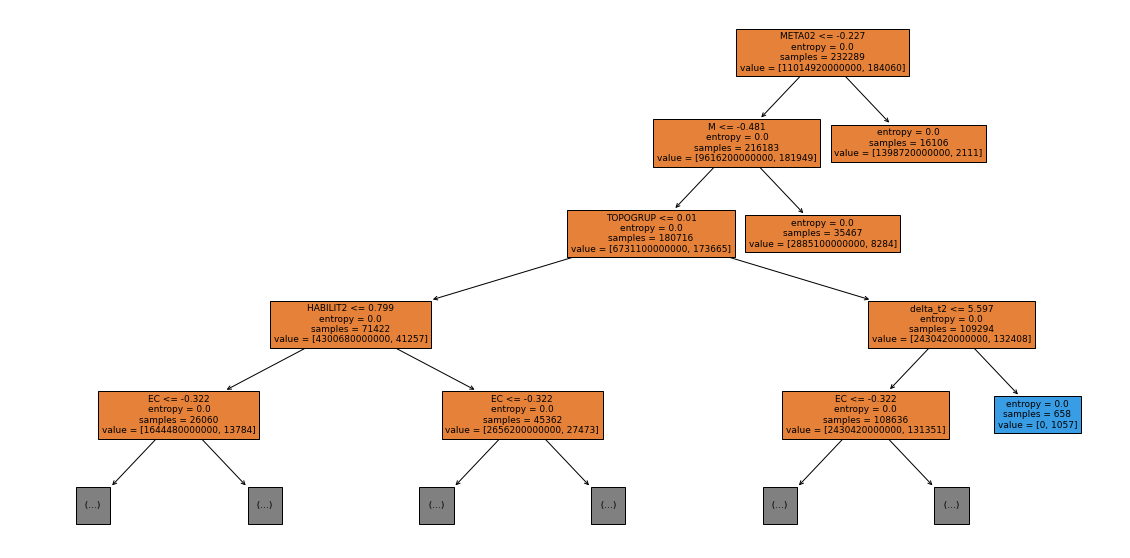

In [ ]:
show_tree(rf_sp, feat_cols_SP, 4)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:75_000_000, 1:1},
                                 criterion='entropy') 
rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 75000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

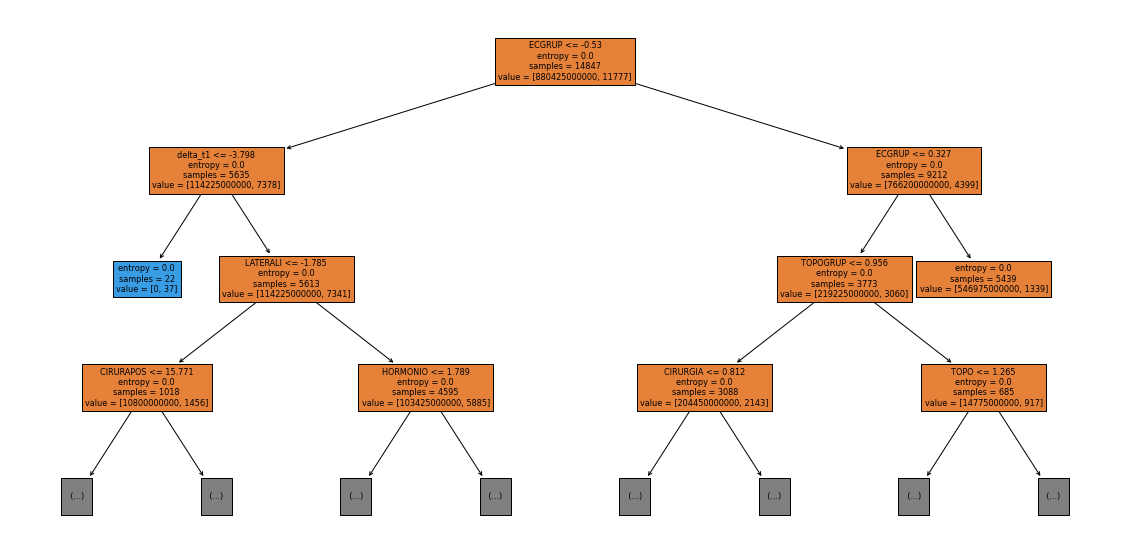

In [ ]:
show_tree(rf_fora, feat_cols_OS, 3)

In [ ]:
# RandomizedSearchCV

hyperRF = {'n_estimators': [100, 300, 500, 800, 1200],
           'max_depth': [5, 8, 15, 25, 30],
           'min_samples_split': [2, 5, 10, 15, 100],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv = 5, verbose = 2, n_jobs=4)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

In [ ]:
# SP
rf_sp_opt = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:100},
                                   max_depth=30, min_samples_leaf=1, 
                                   min_samples_split=2, n_estimators=800)

rf_sp_opt.fit(X_train_SP, y_train_SP)

In [ ]:
plot_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

In [ ]:
# Other states
rf_fora_opt = RandomForestClassifier(random_state=seed, class_weight={0:50, 1:1},
                                     max_depth=30, min_samples_leaf=1, 
                                     min_samples_split=5, n_estimators=300)

rf_fora_opt.fit(X_train_OS, y_train_OS)

In [ ]:
plot_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A lower weight was also used for the class with values 1, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.6,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.35,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# RandomizedSearchCV

hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
            'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
            'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}

xgboost = xgb.XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv = 5, verbose = 2, n_jobs=4)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

In [ ]:
# SP
xgb_sp_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=0.06,
                               colsample_bytree=0.4, gamma=0.2, 
                               learning_rate=0.15, max_depth=10, 
                               min_child_weight=5)

xgb_sp_opt.fit(X_train_SP, y_train_SP)

In [ ]:
plot_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.5min finished


In [ ]:
bestOS.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.4,
 'learning_rate': 0.2,
 'max_depth': 12,
 'min_child_weight': 1}

In [ ]:
# Other states
xgb_fora_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=0.35,
                                 colsample_bytree=0.5, gamma=0.4, 
                                 learning_rate=0.2, max_depth=12, 
                                 min_child_weight=1)

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

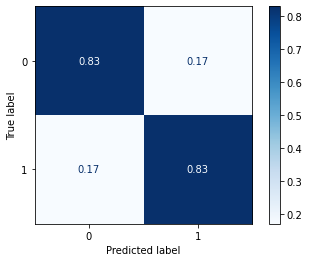

In [ ]:
plot_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

## **Results**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

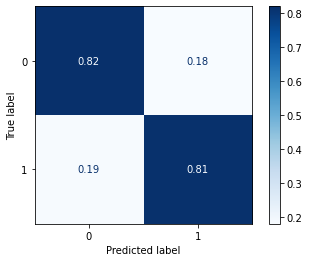

In [ ]:
plot_confusion_matrix(rf_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 81% of accuracy.

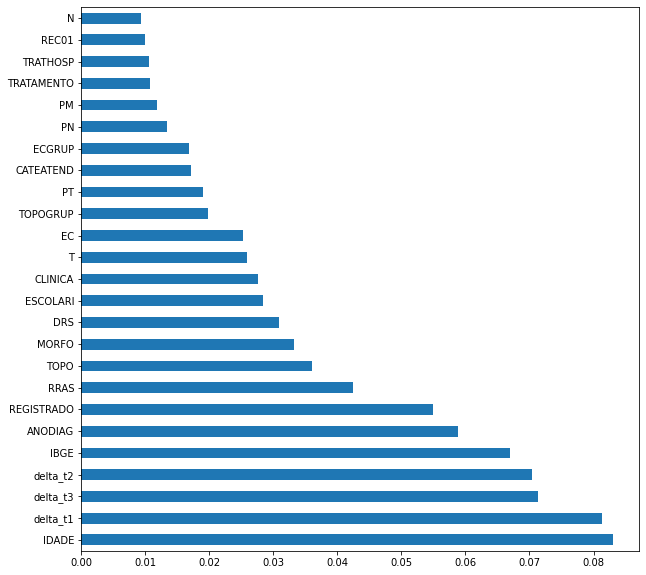

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`. The last three being the difference, in days, between diagnosis and consultation, treatment and consultation and treatment and diagnosis, respectively.

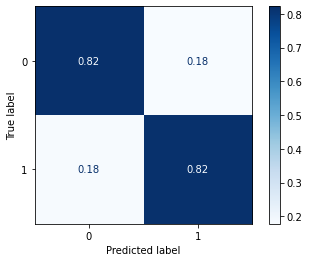

In [ ]:
plot_confusion_matrix(rf_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 82% of accuracy.


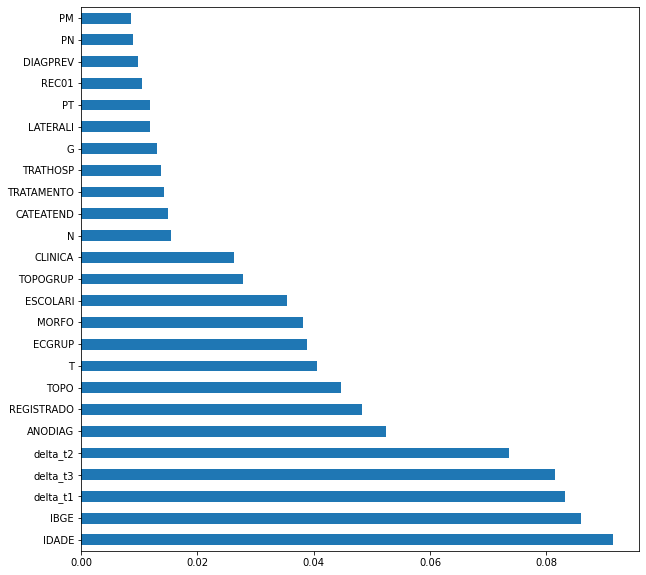

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`. `delta_t1` is the difference between diagnosis and consultation, and `delta_t3` is the deffence between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

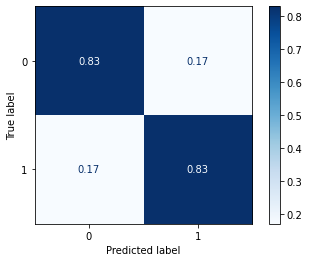

In [ ]:
plot_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, similar to the Random Forest model. The accuracy was 83%.

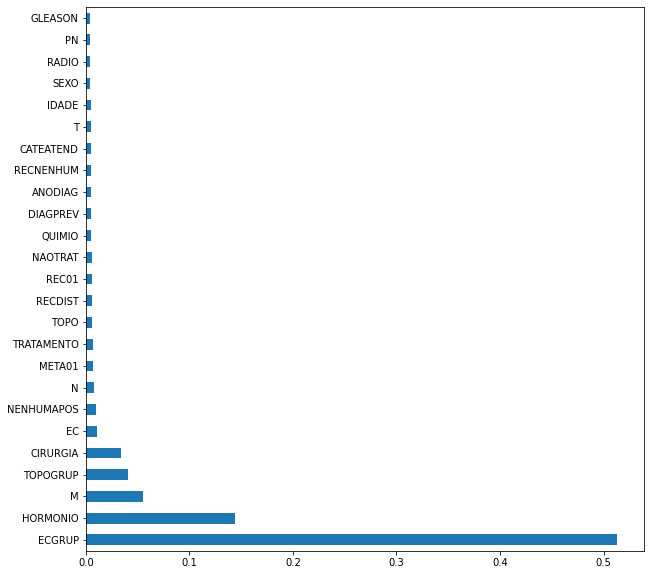

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, with a lot advantage, `HORMONIO`, `M` and `TOPOGRUP`.

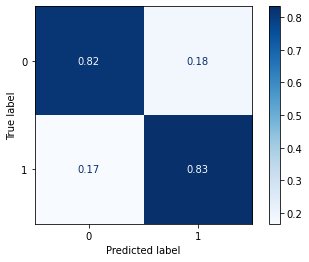

In [ ]:
plot_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost, with other states data, also shows a good performance of the model, with 82% of accuracy. 

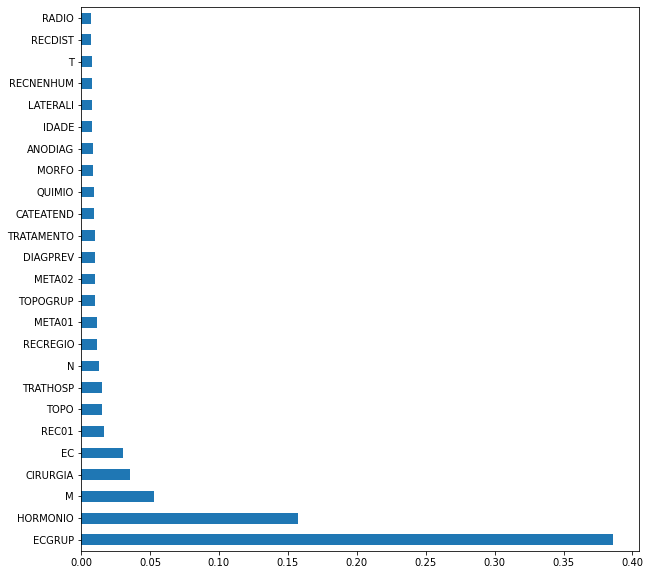

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with a good advantage, `HORMONIO`, `M` and `CIRURGIA`.

# **Second approach**

Approach without column `EC` as a feature.

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 93)

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 93)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`.The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'obito_geral',
             'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec',
             'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, random_state=seed)

X_train = (367642, 65), X_test = (102296, 65)
y_train = (367642,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, random_state=seed)

X_train = (23516, 65), X_test = (6320, 65)
y_train = (23516,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:60_000_000, 1:1},
                               criterion='entropy')
rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

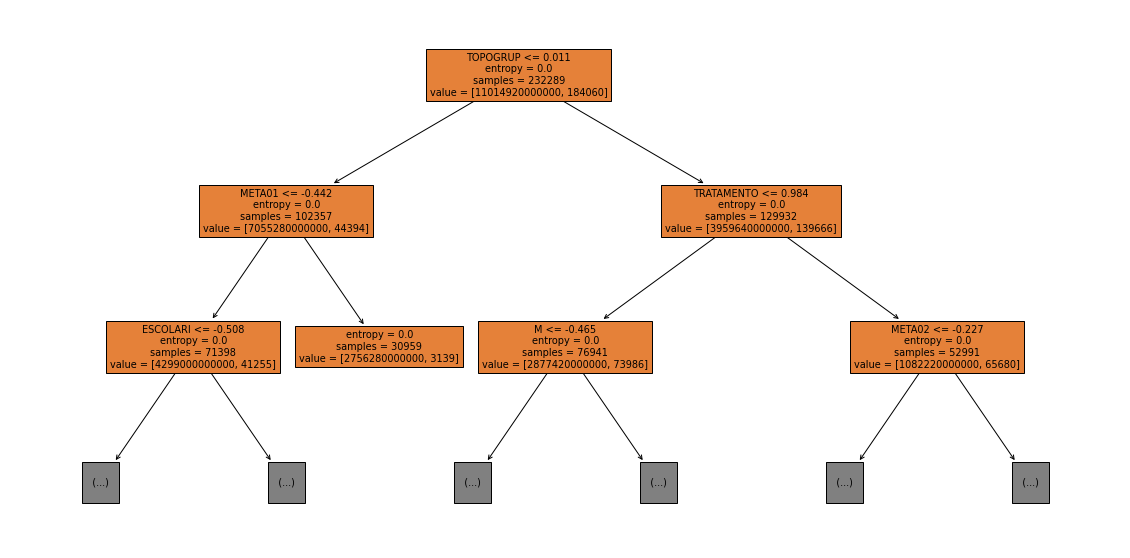

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:75_000_000, 1:1}, 
                                 criterion='entropy') 
rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 75000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

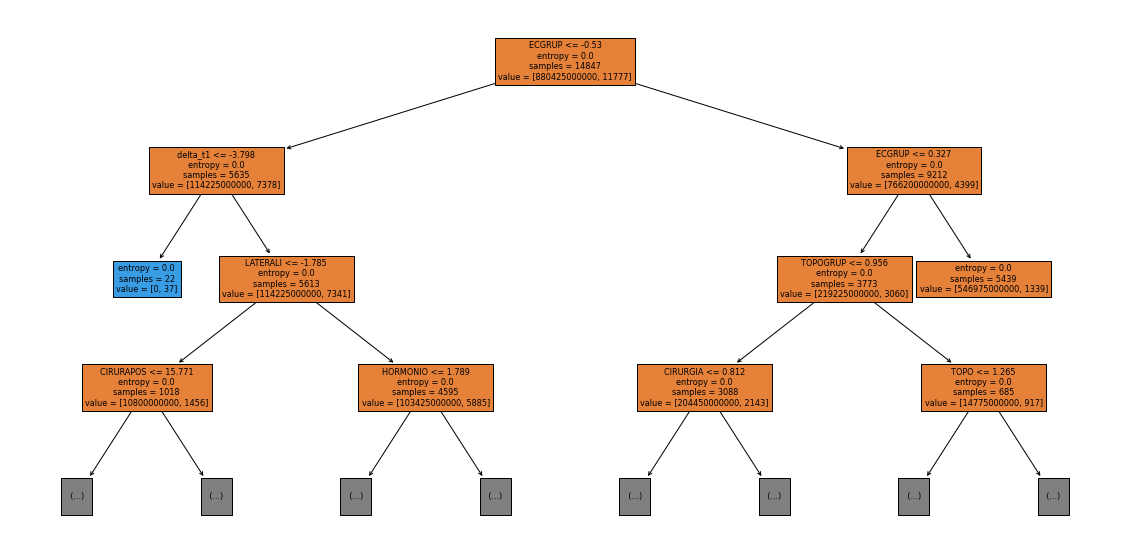

In [ ]:
show_tree(rf_fora, feat_cols_OS, 3)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A lower weight was also used for the class with values 1, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.6,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.35,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Results**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

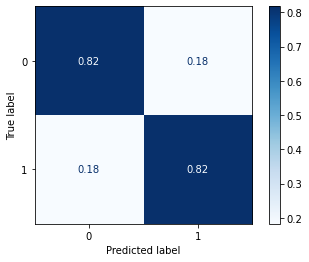

In [ ]:
plot_confusion_matrix(rf_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 82% of accuracy.

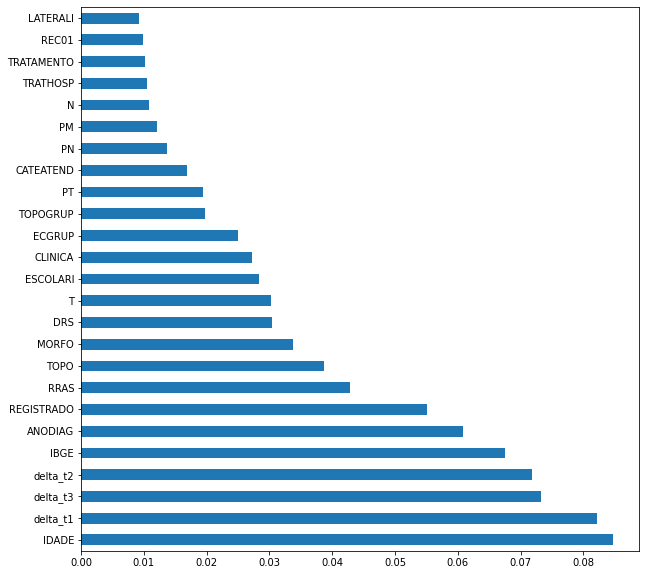

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`. The last three being the difference, in days, between diagnosis and consultation, treatment and consultation and treatment and diagnosis, respectively.

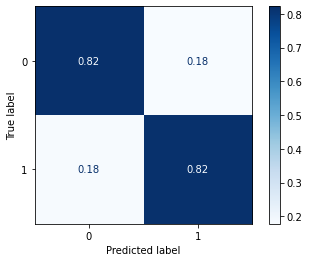

In [ ]:
plot_confusion_matrix(rf_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 82% of accuracy.


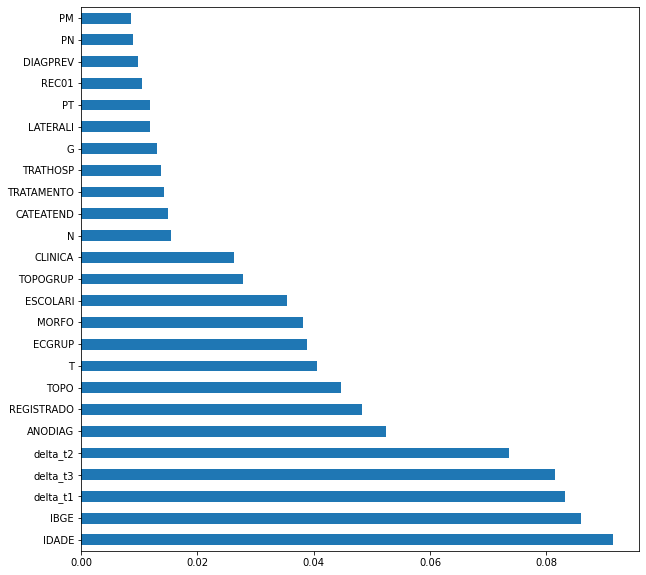

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`. `delta_t1` is the difference between diagnosis and consultation, and `delta_t3` is the deffence between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

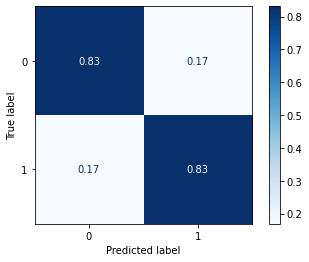

In [ ]:
plot_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model. The accuracy was 83%.

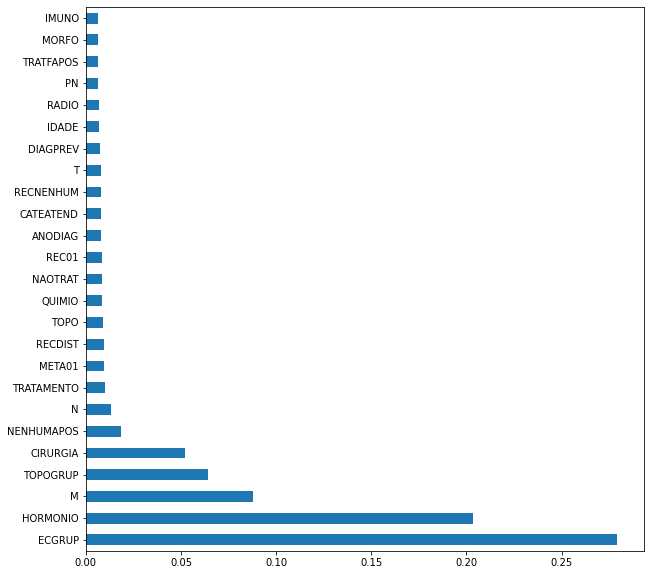

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `TOPOGRUP`.

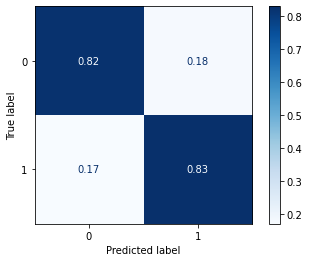

In [ ]:
plot_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 82% of accuracy. 

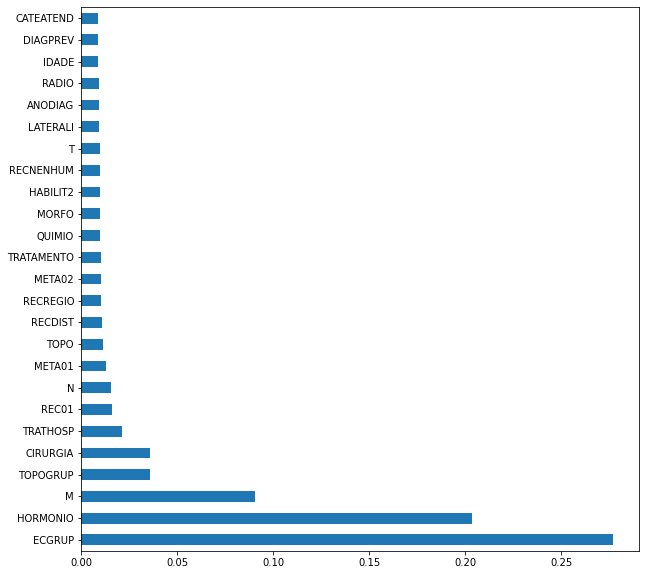

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `CIRURGIA`.

# **Third approach**

Approach without columns `EC` and `HORMONIO` as features.

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 93)

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 93)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`.The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'obito_geral',
             'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec',
             'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, random_state=seed)

X_train = (367642, 64), X_test = (102296, 64)
y_train = (367642,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, random_state=seed)

X_train = (23516, 64), X_test = (6320, 64)
y_train = (23516,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:60_000_000, 1:1},
                               criterion='entropy')
rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

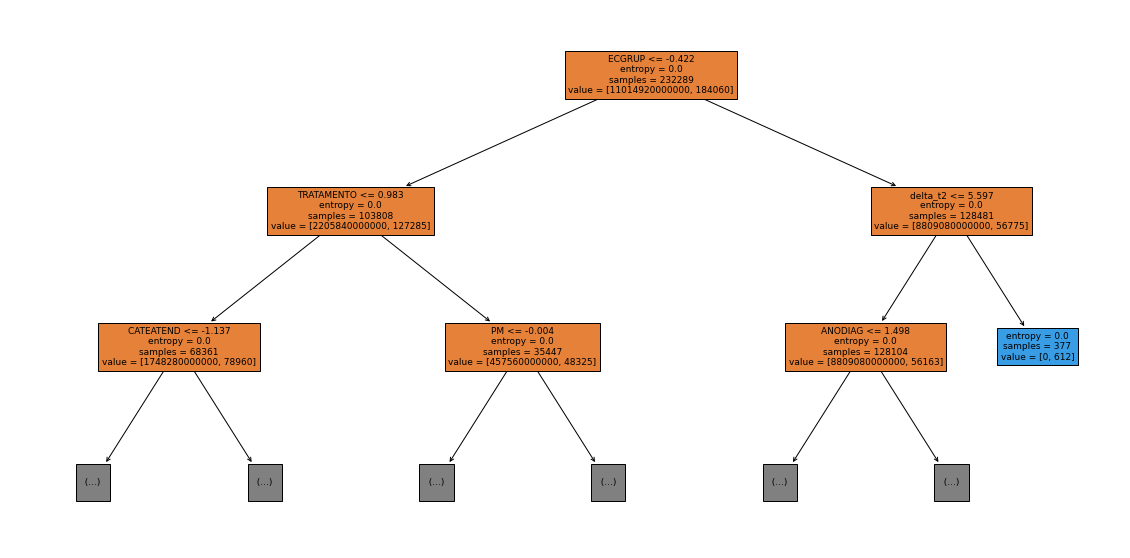

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:75_000_000, 1:1}, 
                                 criterion='entropy') 
rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 75000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

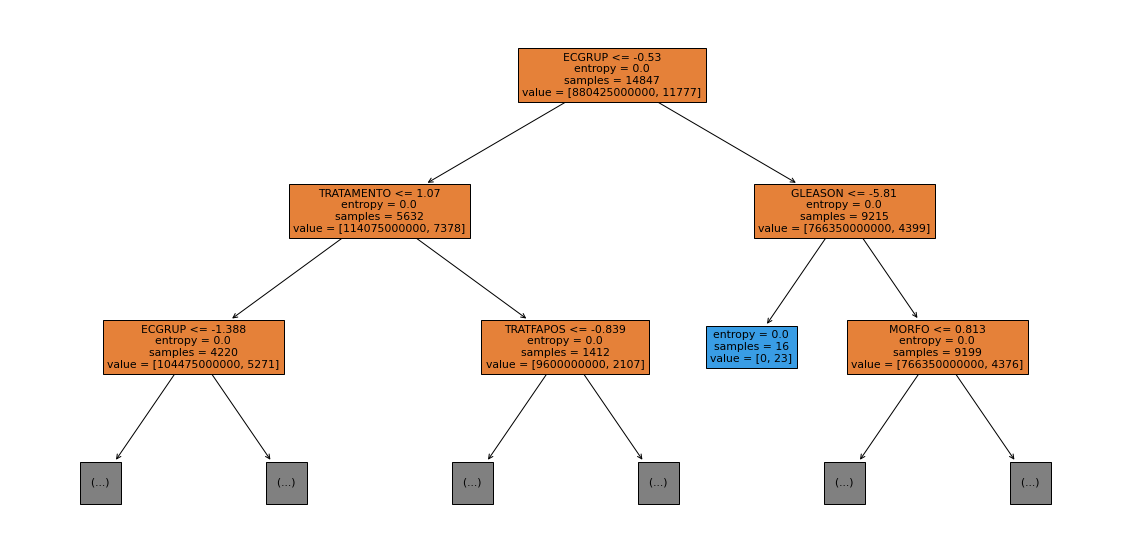

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A lower weight was also used for the class with values 1, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.6,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.32,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.32, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Results**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

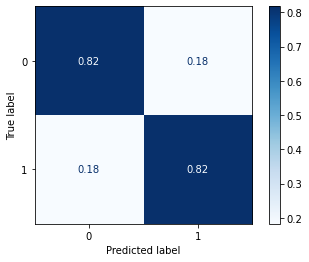

In [ ]:
plot_confusion_matrix(rf_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 82% of accuracy.

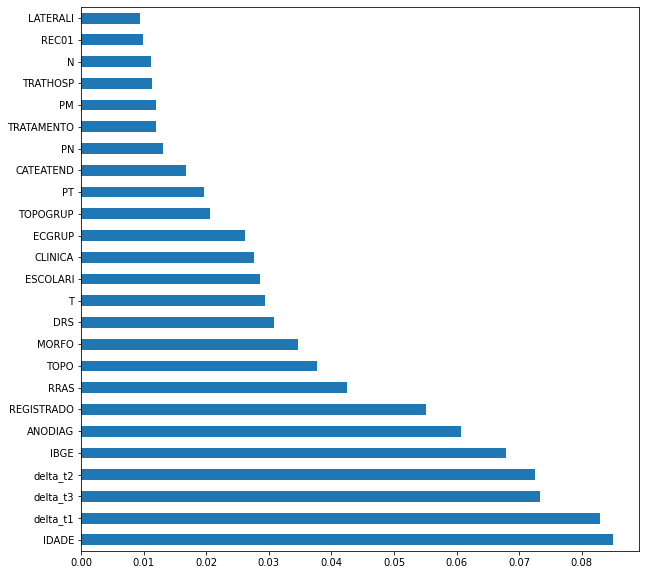

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`. The last three being the difference, in days, between diagnosis and consultation, treatment and consultation and treatment and diagnosis, respectively.

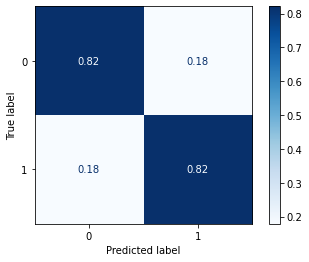

In [ ]:
plot_confusion_matrix(rf_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 82% of accuracy.


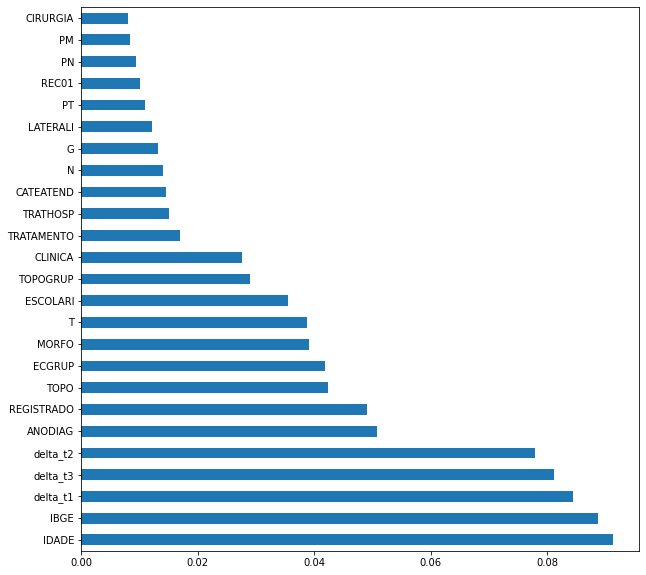

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`. `delta_t1` is the difference between diagnosis and consultation, and `delta_t3` is the deffence between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

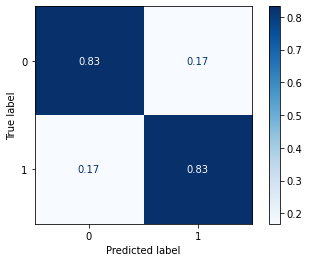

In [ ]:
plot_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model. The accuracy was 83%.

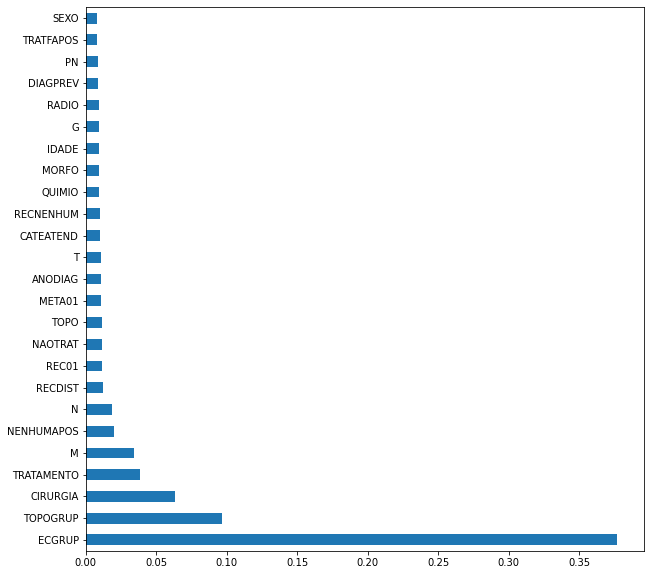

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `CIRURGIA` and `TRATAMENTO`.

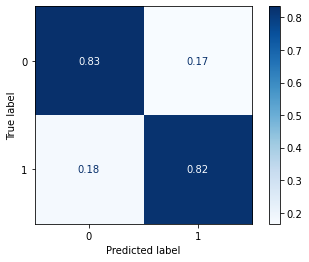

In [ ]:
plot_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 82% of accuracy. 

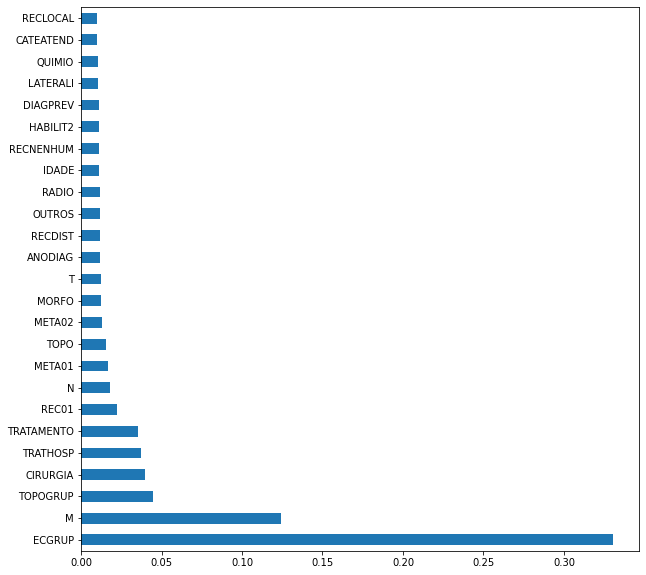

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `CIRURGIA`.

# **Fourth approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

**SP**

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 93)

**Other states**

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 93)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'obito_geral',
             'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec',
             'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

X_train = (53228, 65), X_test = (15329, 65)
y_train = (53228,), y_test = (15329,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

X_train = (70060, 65), X_test = (19267, 65)
y_train = (70060,), y_test = (19267,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

X_train = (97274, 65), X_test = (25886, 65)
y_train = (97274,), y_test = (25886,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

X_train = (115836, 65), X_test = (29854, 65)
y_train = (115836,), y_test = (29854,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2021, 
                                                                                                random_state=seed)

X_train = (40680, 65), X_test = (11961, 65)
y_train = (40680,), y_test = (11961,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (3108, 65), X_test = (877, 65)
y_train = (3108,), y_test = (877,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (4648, 65), X_test = (1218, 65)
y_train = (4648,), y_test = (1218,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (5732, 65), X_test = (1463, 65)
y_train = (5732,), y_test = (1463,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (7310, 65), X_test = (1782, 65)
y_train = (7310,), y_test = (1782,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2020, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (3186, 65), X_test = (981, 65)
y_train = (3186,), y_test = (981,)


## **Training and validation of the models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because even after balancing the data the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:60_000_000, 1:1},
                                     criterion='entropy')
rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

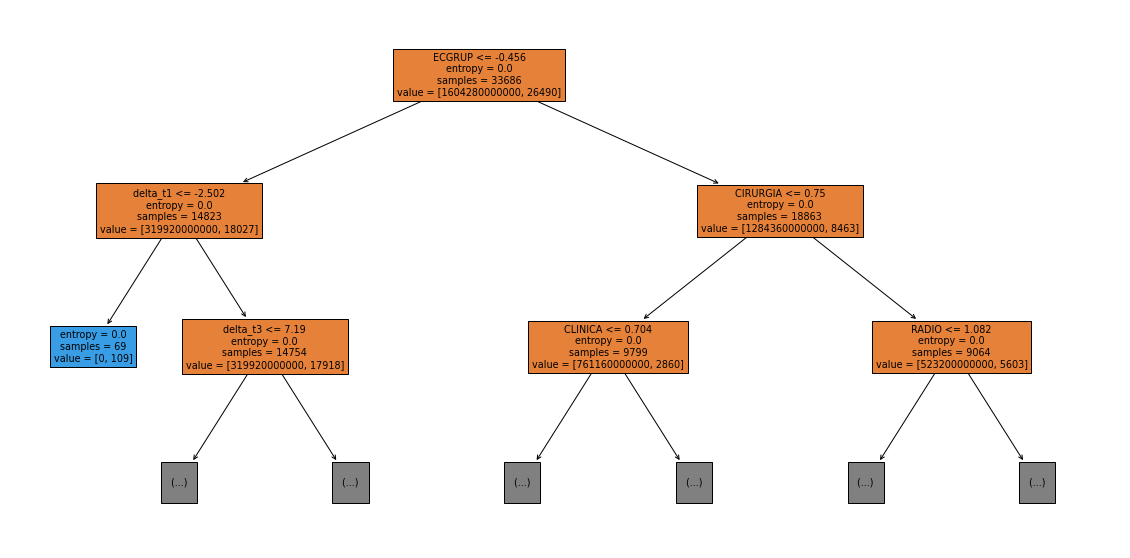

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

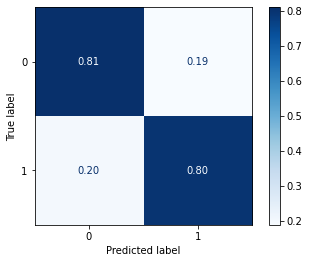

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2000 to 2003, shows a good performance, with 80% of accuracy.

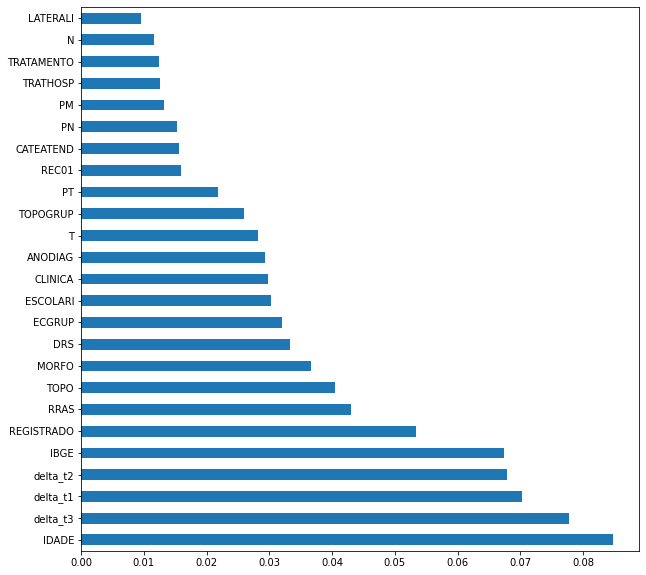

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `IDADE`, `delta_t3`, `delta_t1` and `delta_t2`.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:60_000_000, 1:1},
                                     criterion='entropy')
rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

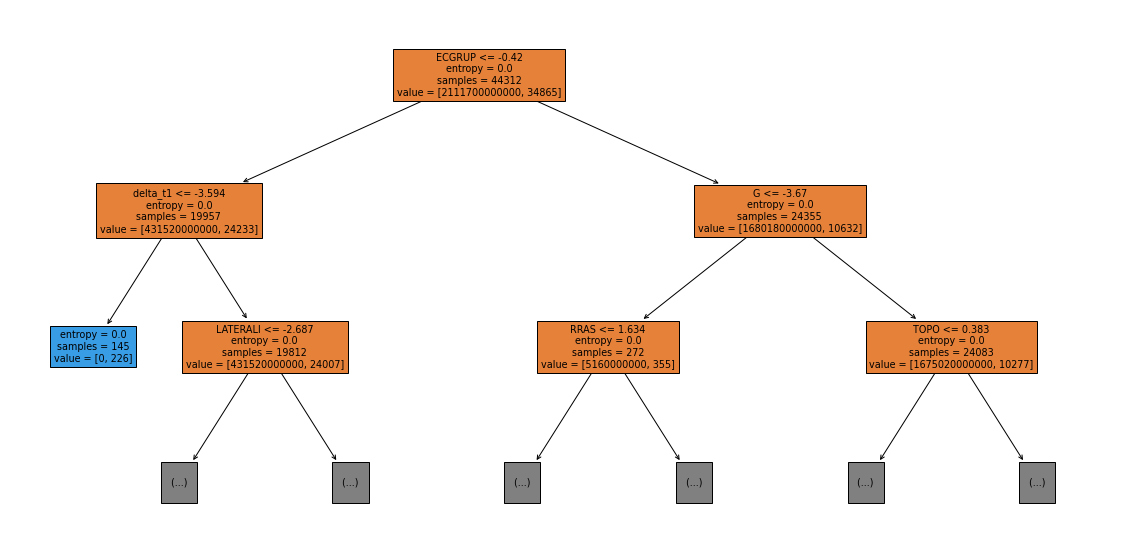

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

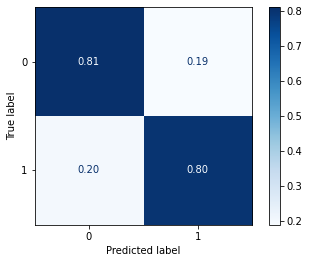

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

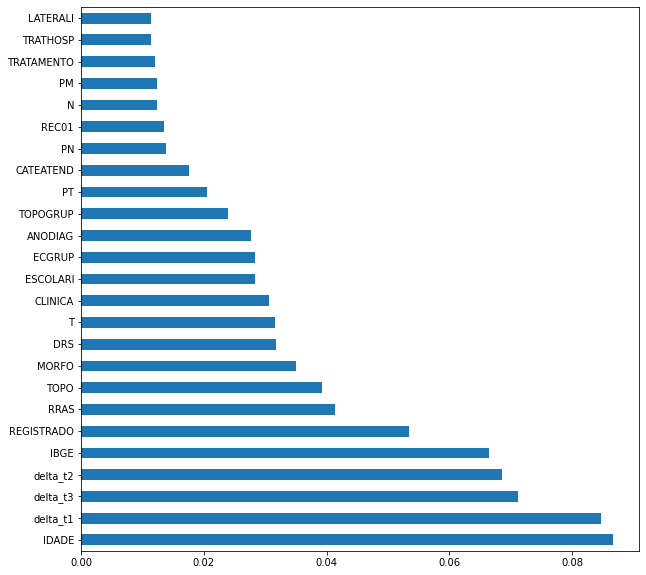

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:60_000_000, 1:1},
                                     criterion='entropy')
rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

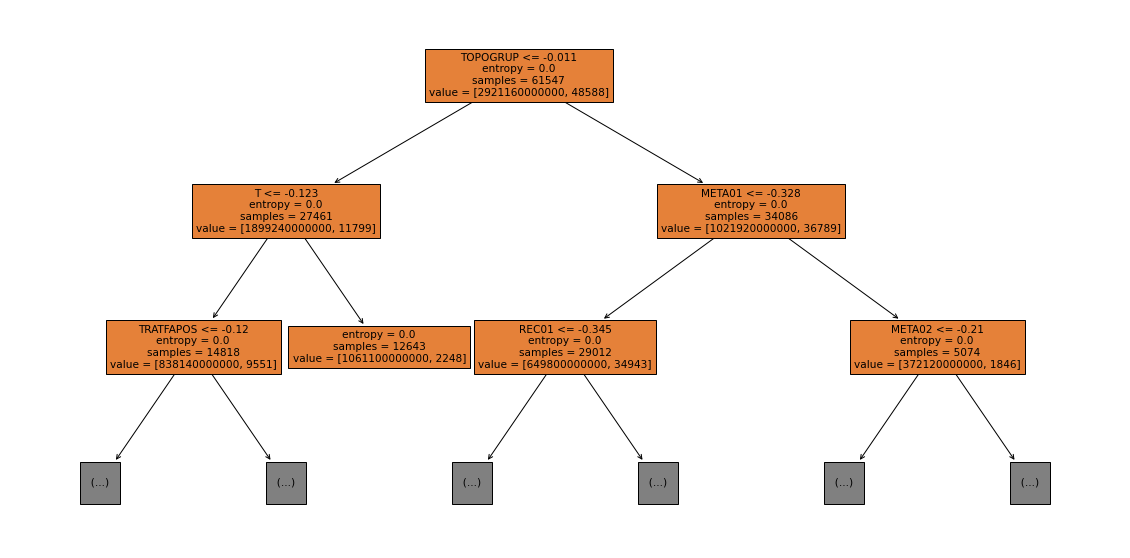

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

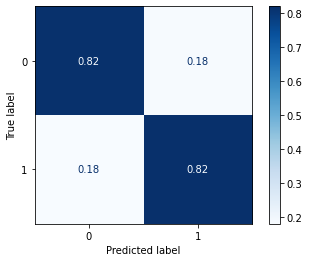

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuray.

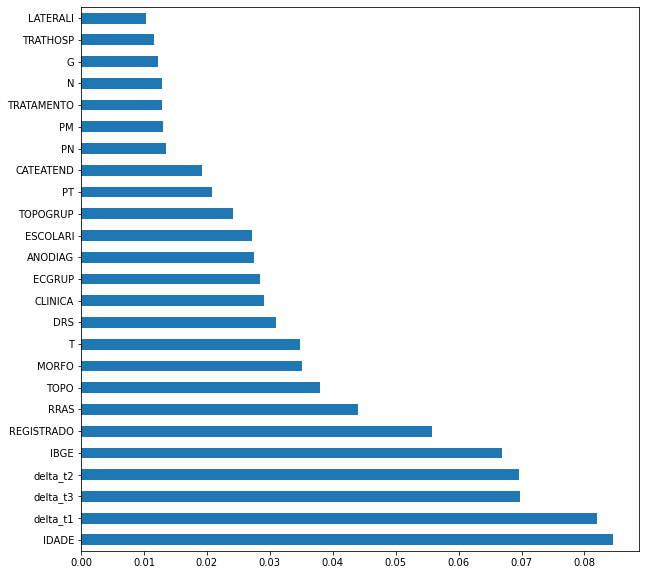

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:70_000_000, 1:1},
                                     criterion='entropy')
rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 70000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

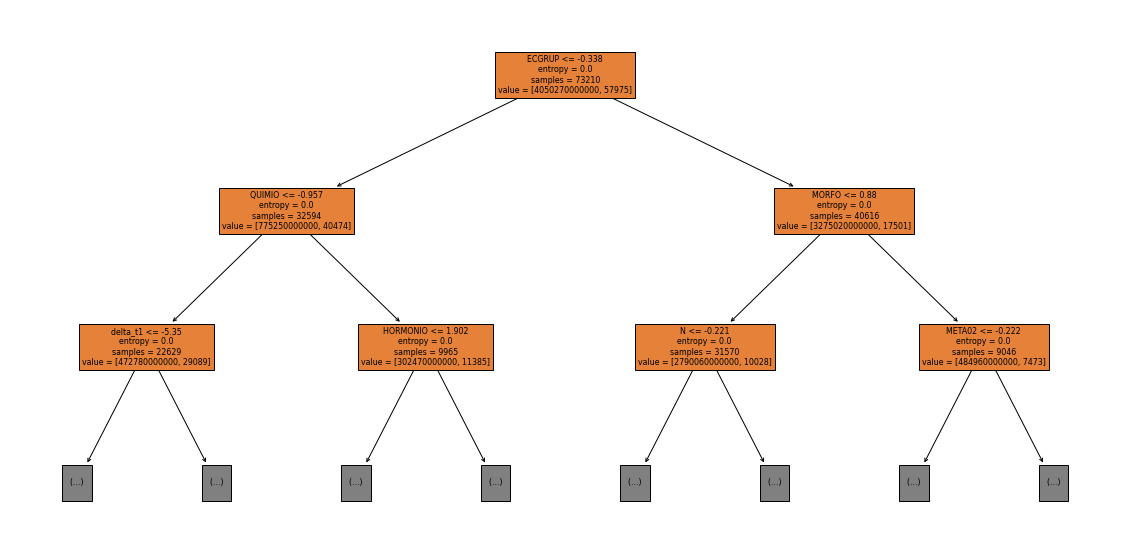

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

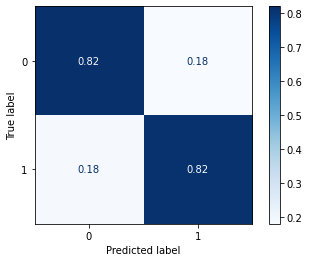

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

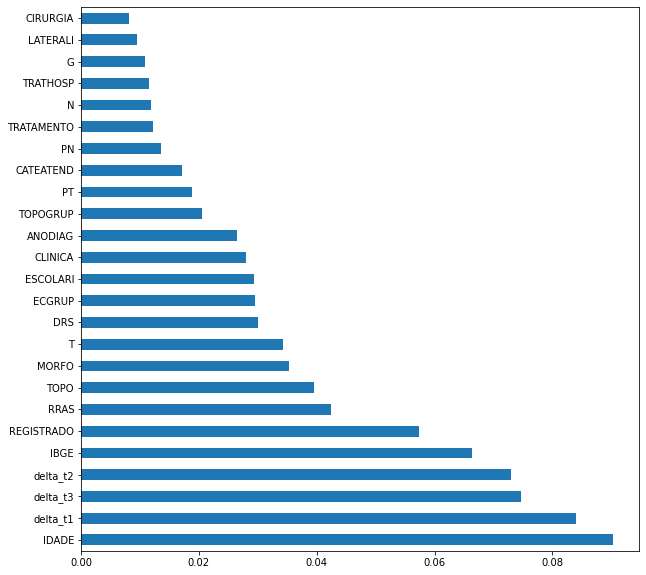

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:28_000_000, 1:1},
                                     criterion='entropy')
rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 28000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

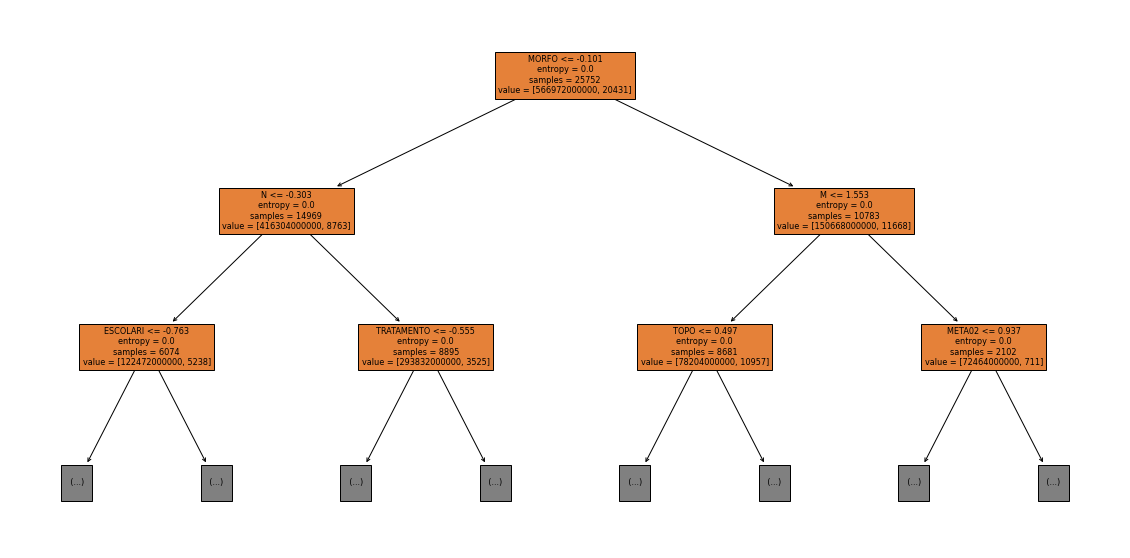

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

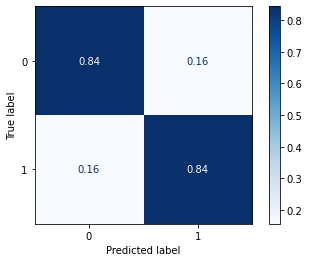

In [ ]:
plot_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model. The accuracy was 84%.

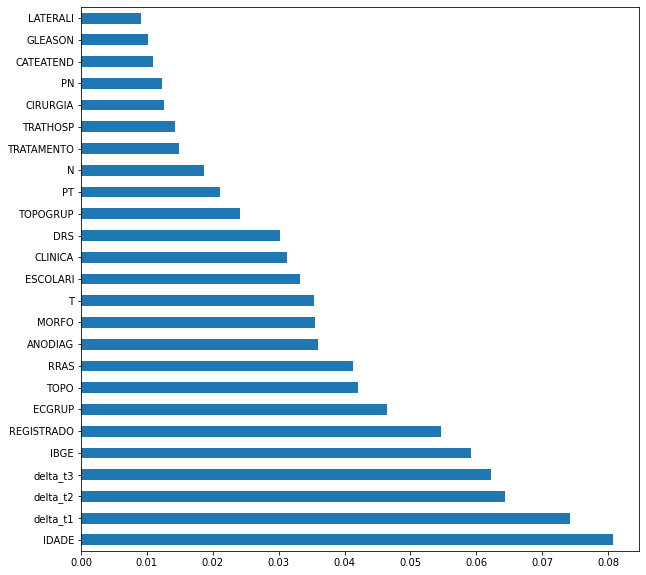

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `delta_t3`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:100_000_000, 1:1},
                                       criterion='entropy')
rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 100000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

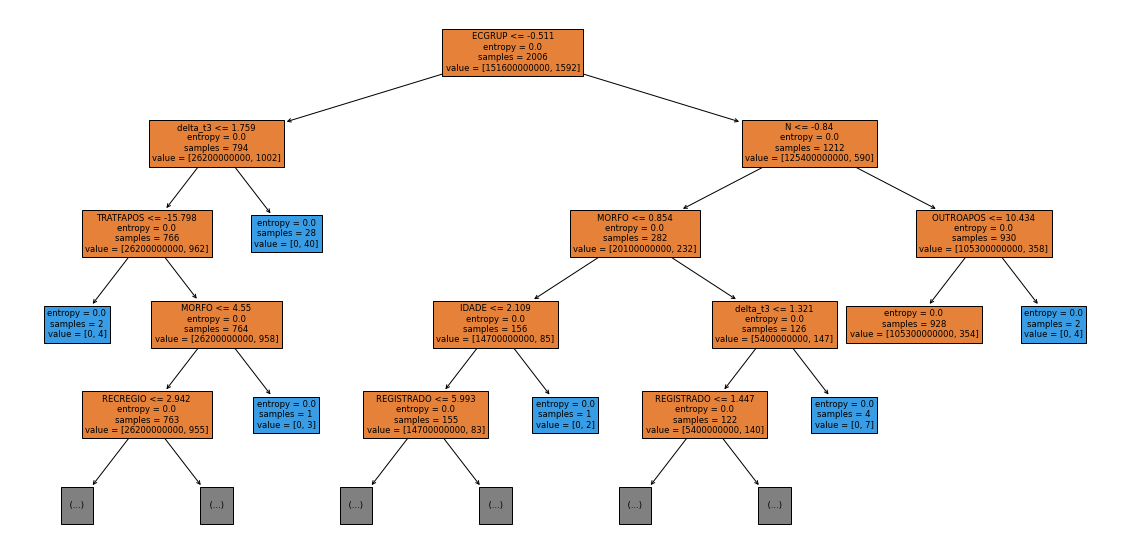

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 4)

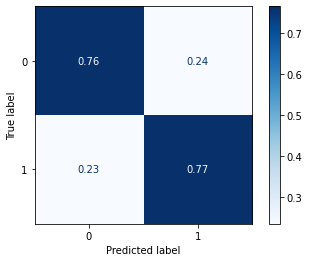

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix. The accuracy was 76%.

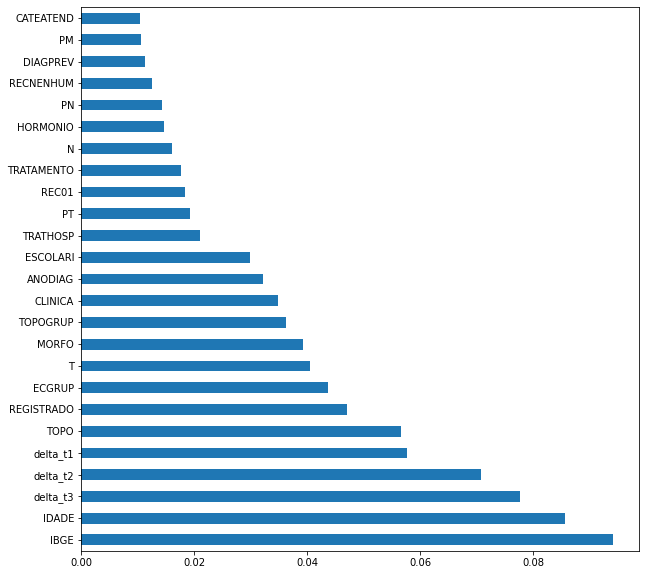

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `IBGE`, `IDADE`, `delta_t3` and `delta_t2`.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:60_000_000, 1:1},
                                       criterion='entropy')
rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

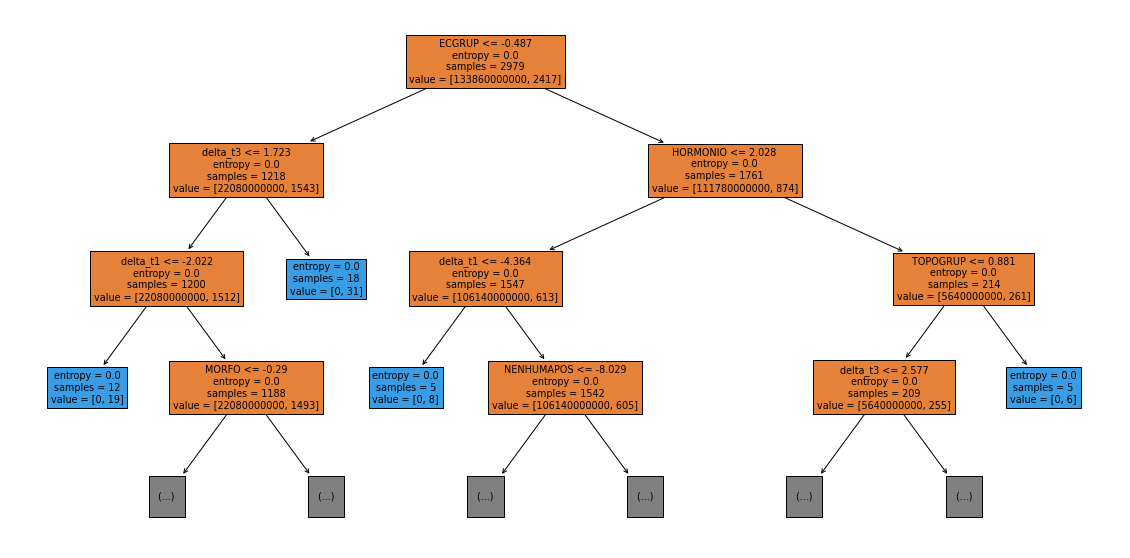

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 3)

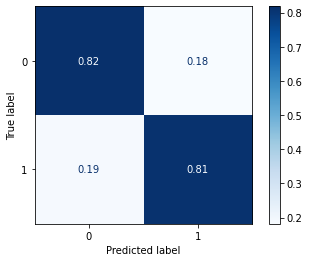

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 81% of accuracy.


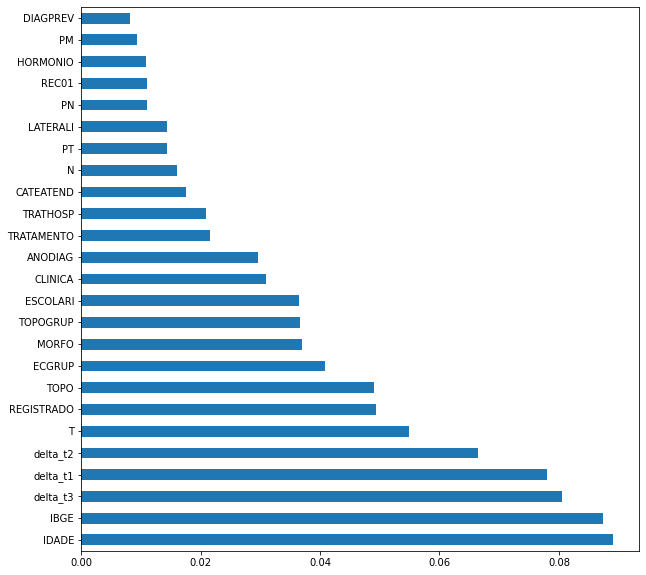

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t3` and `delta_t1`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:60_000_000, 1:1},
                                       criterion='entropy')
rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

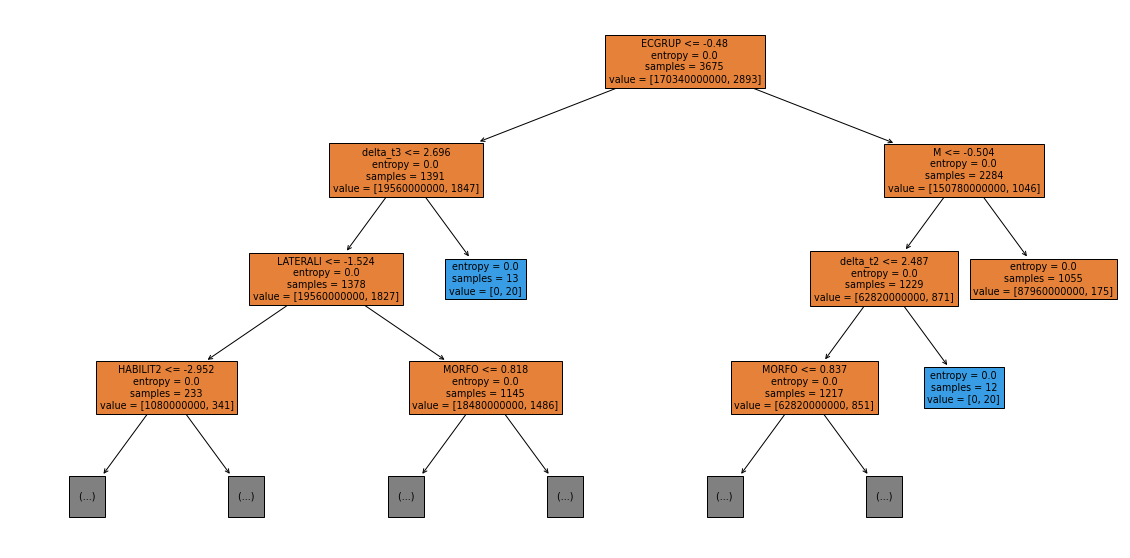

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 3)

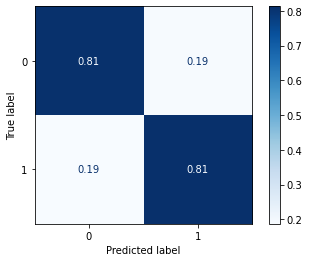

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, with 81% of accuracy.


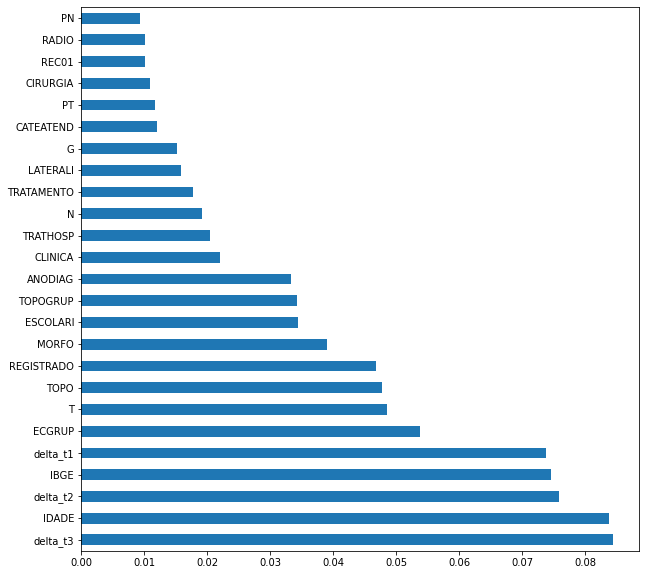

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `delta_t3`, `IDADE`, `delta_t2` and `IBGE`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:80_000_000, 1:1},
                                       criterion='entropy')
rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 80000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

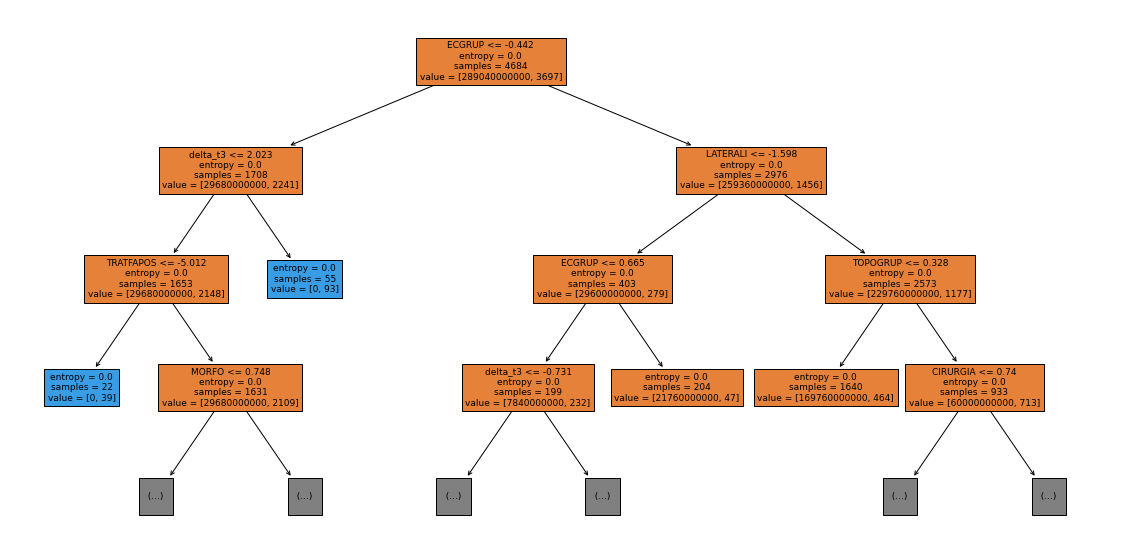

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 3)

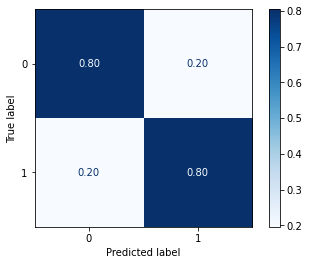

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 80% of accuracy.


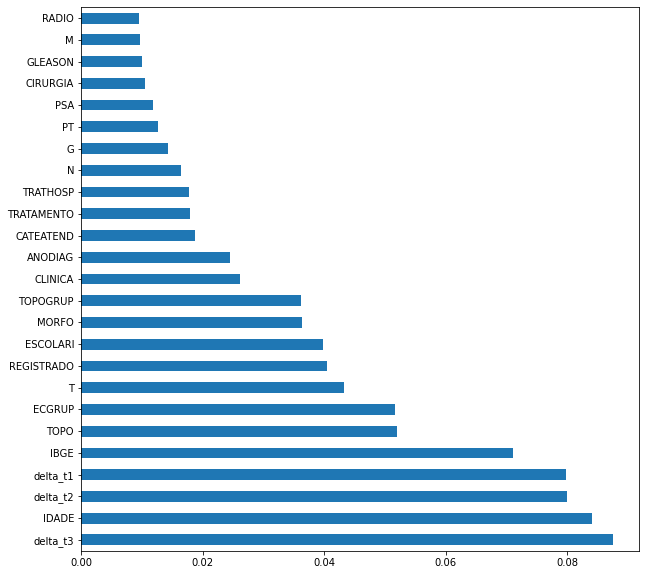

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `delta_t3`, `IDADE`, `delta_t2` and `delta_t1`.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:30_000_000, 1:1},
                                       criterion='entropy')
rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 30000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

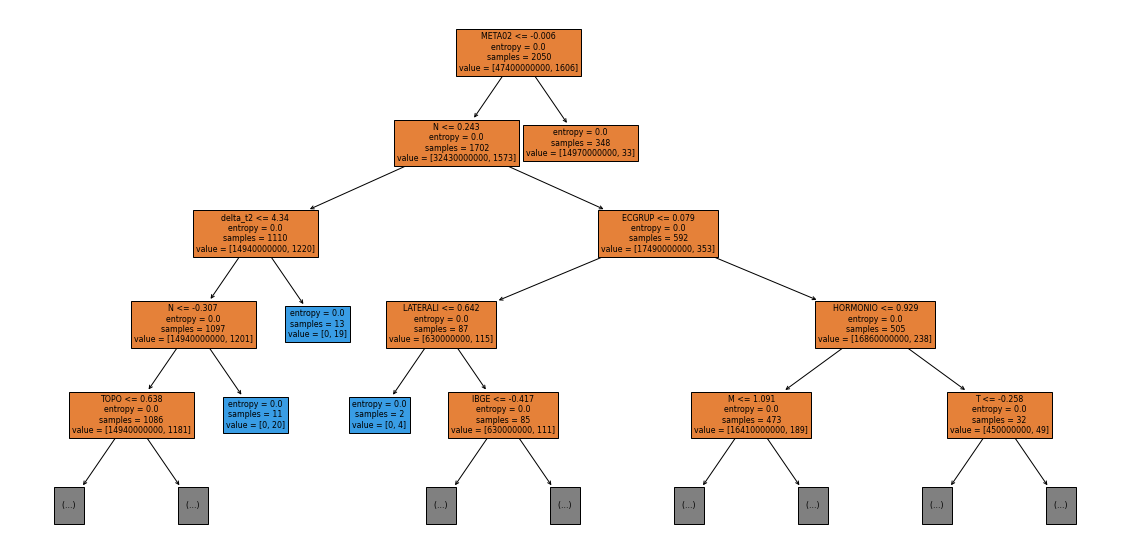

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 4)

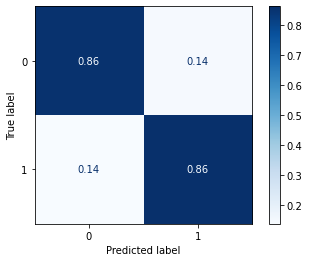

In [ ]:
plot_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance, the accuracy was 86%.




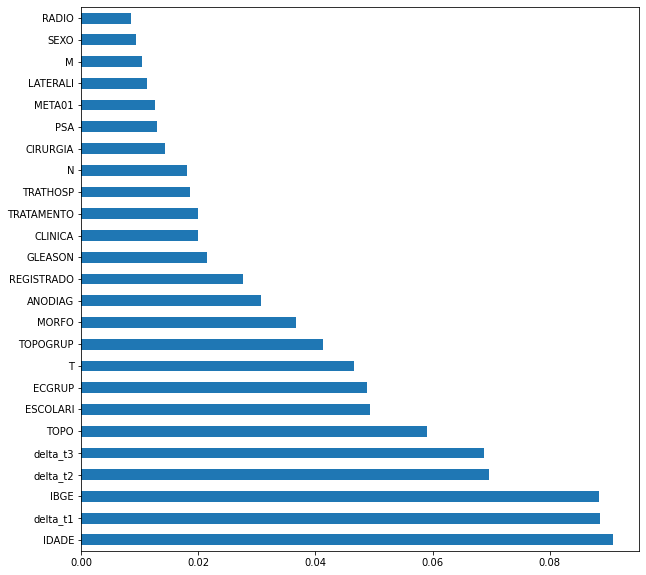

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t2`.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.55)
xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.55, seed=None,
              silent=None, subsample=1, verbosity=1)

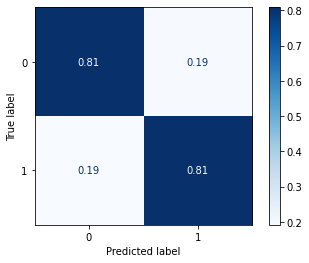

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, as well as the Random Forest model, here with 81% of accuracy.

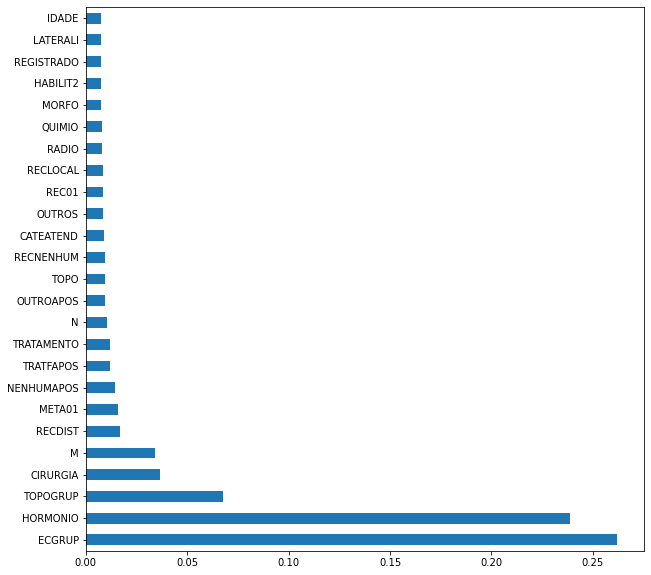

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `TOPOGRUP` and `CIRURGIA`.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.55)
xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.55, seed=None,
              silent=None, subsample=1, verbosity=1)

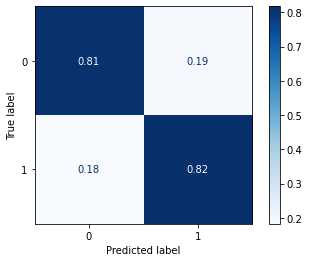

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.

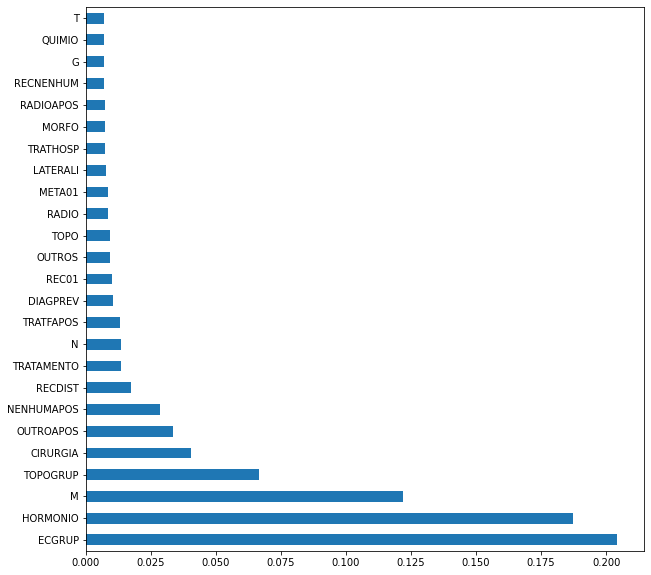

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `TOPOGRUP`.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.4)
xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4, seed=None,
              silent=None, subsample=1, verbosity=1)

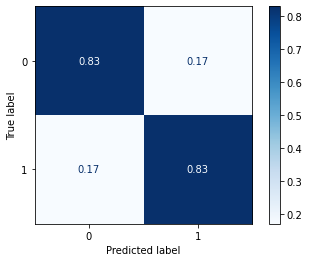

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

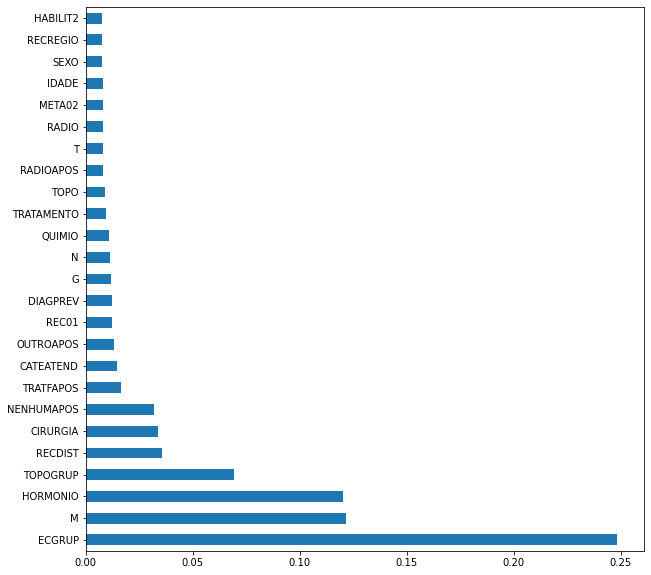

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, with some advantage, `M`, `HORMONIO` and `TOPOGRUP`.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.35)
xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

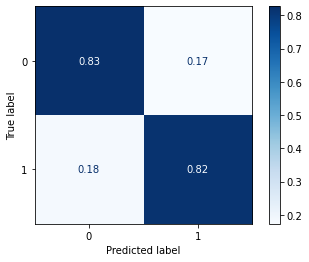

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

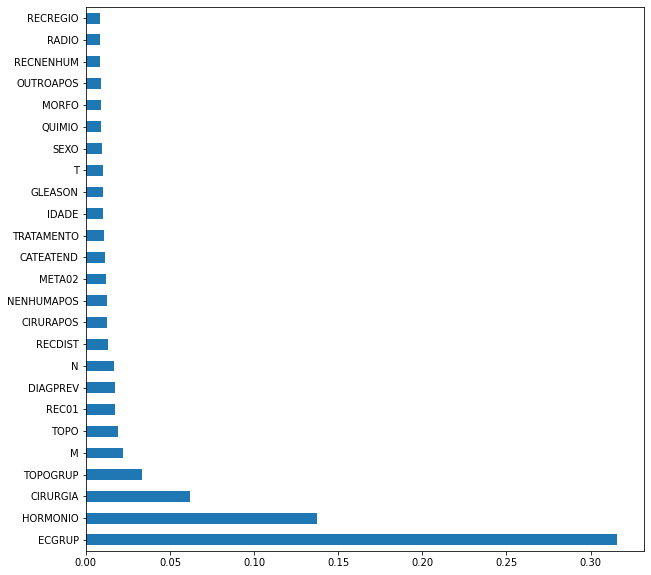

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, with a good advantage, `HORMONIO`, `CIRURGIA` and `TOPOGRUP`.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=1.3)
xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.3, seed=None,
              silent=None, subsample=1, verbosity=1)

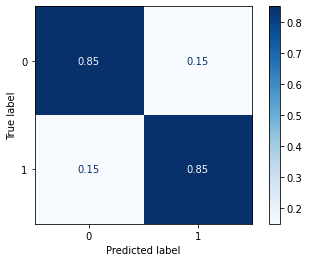

In [ ]:
plot_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.



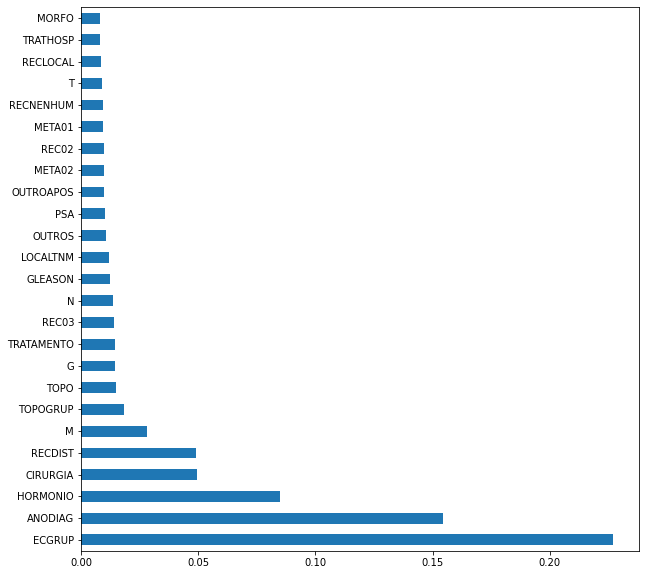

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `HORMONIO` and `CIRURGIA`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                   scale_pos_weight=0.27)
xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.27, seed=None,
              silent=None, subsample=1, verbosity=1)

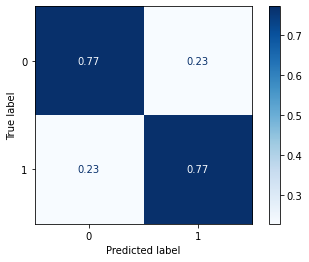

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 77% of accuracy.

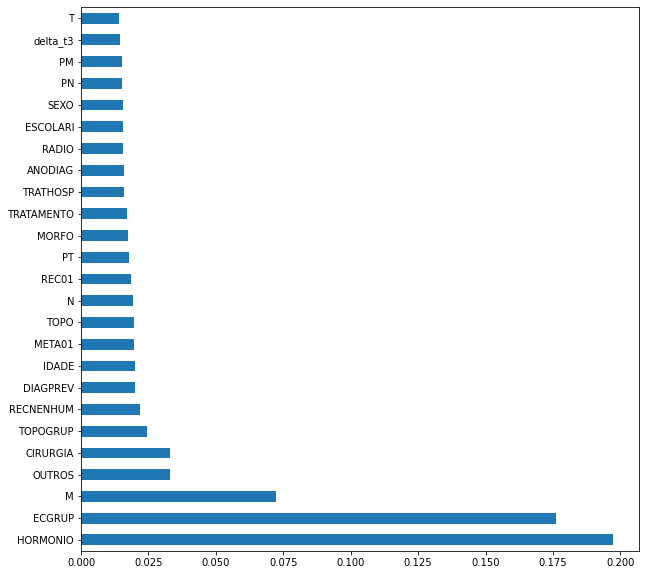

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> The two most important features in the model were `HORMONIO`, `ECGRUP`, `M` and `OUTROS`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.27,
                                   random_state=seed)
xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.27, seed=None,
              silent=None, subsample=1, verbosity=1)

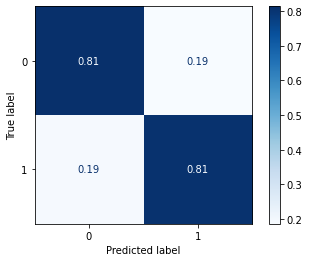

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

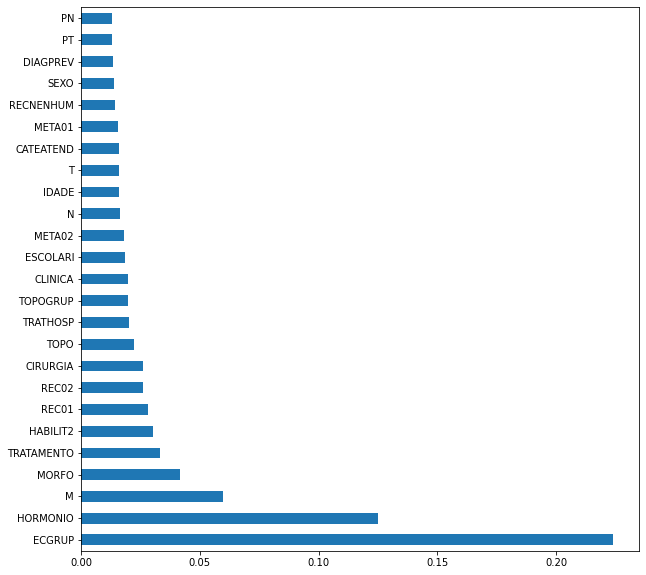

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> The two most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `MORFO`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.25,
                                   random_state=seed)
xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25, seed=None,
              silent=None, subsample=1, verbosity=1)

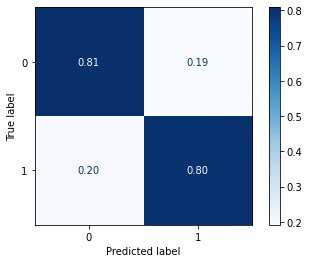

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, presented 80% of accuracy.

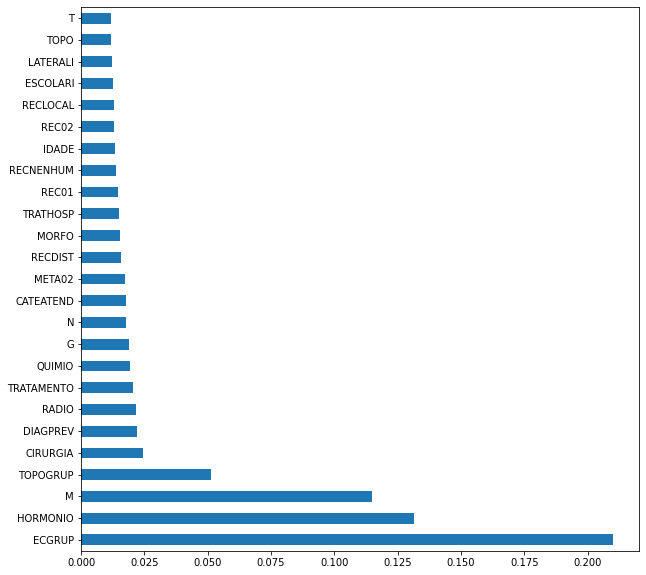

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `TOPOGRUP`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.2,
                                   random_state=seed)
xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.2, seed=None,
              silent=None, subsample=1, verbosity=1)

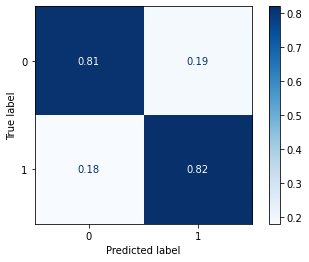

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, presented 81% of accuracy.

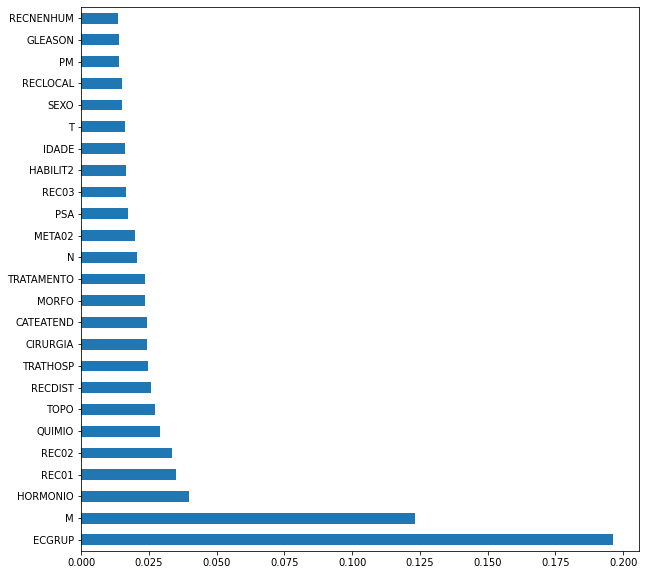

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `HORMONIO` and `REC01`.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1,
                                  random_state=seed)
xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

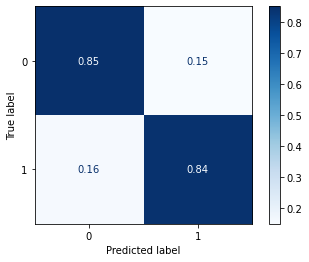

In [ ]:
plot_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows a good performance, with 84% of accuracy.

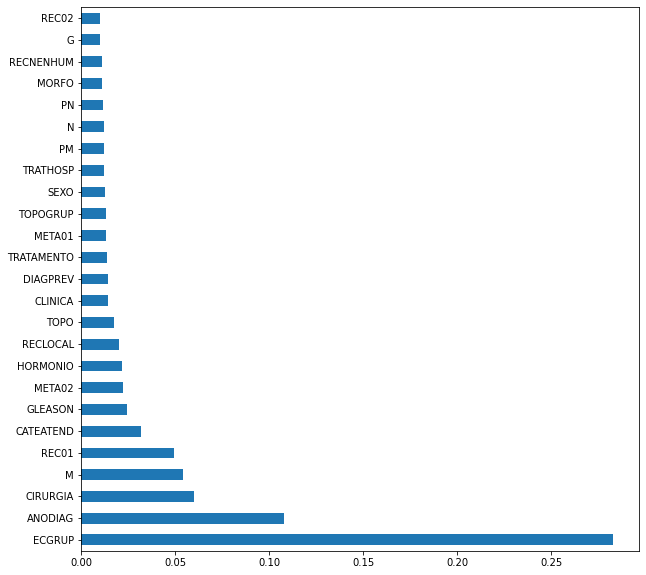

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, with a good advantage, `ANODIAG`, `CIRURGIA` and `M`.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

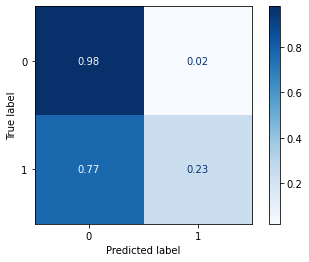

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

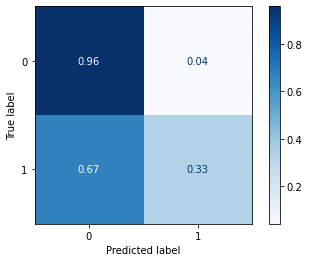

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

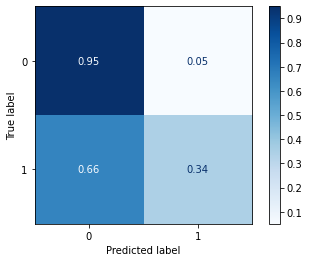

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

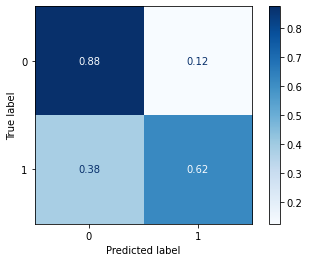

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2000 to 2003**

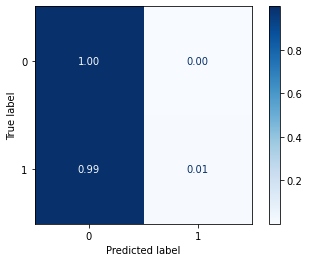

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

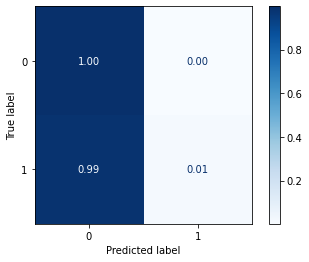

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

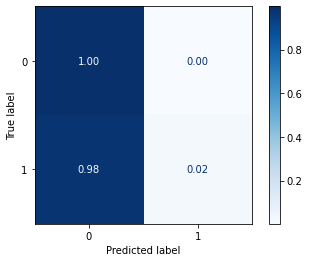

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

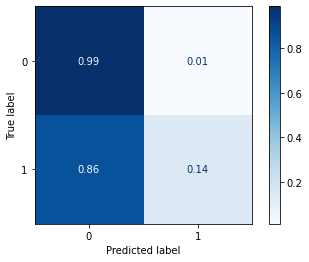

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2004 to 2007**

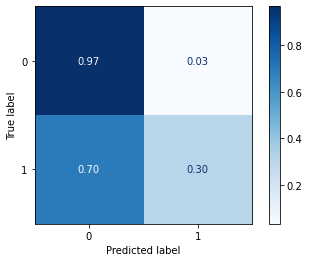

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

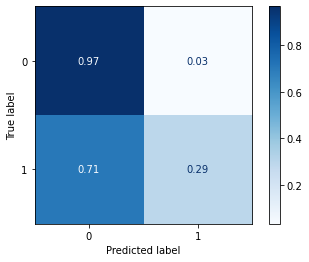

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

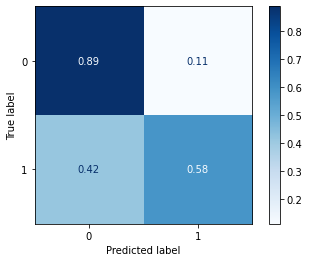

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2004 to 2007**

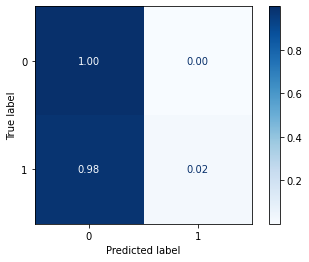

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

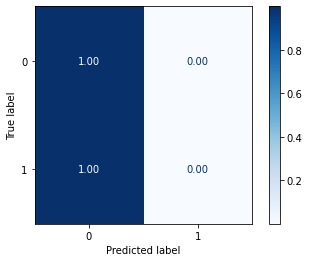

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

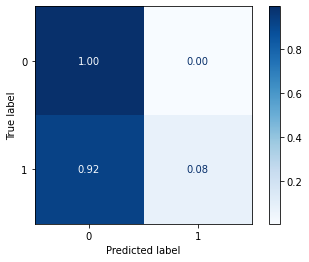

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2008 to 2011**

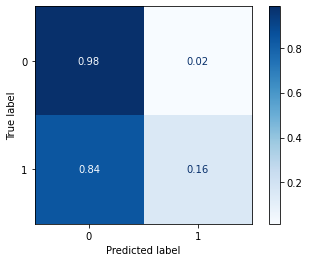

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

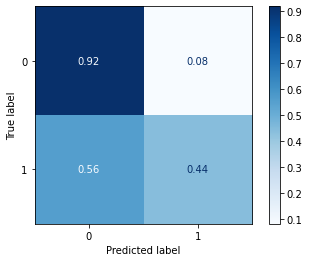

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2008 to 2011**

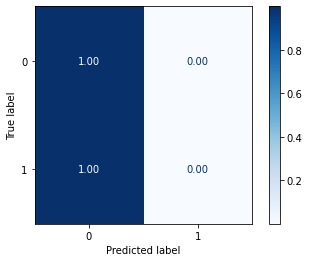

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

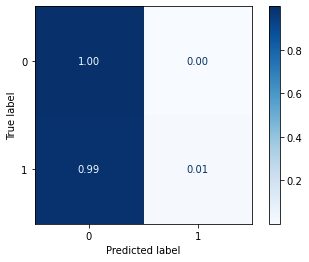

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2012 to 2015**

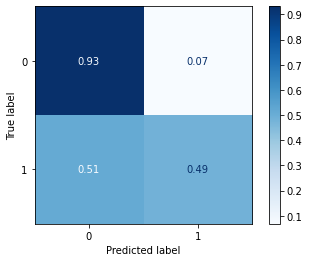

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2012 to 2015**

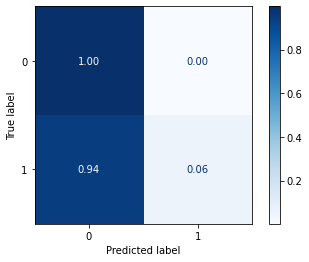

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2000 to 2003**

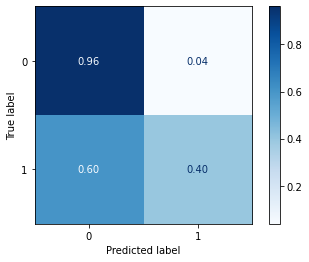

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

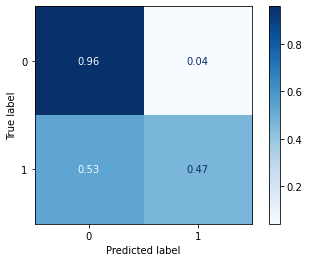

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

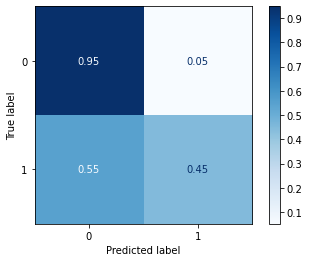

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

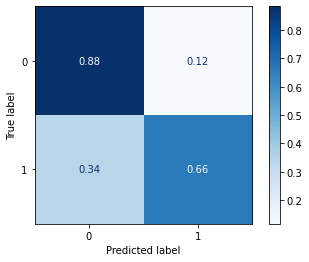

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2000 to 2003**

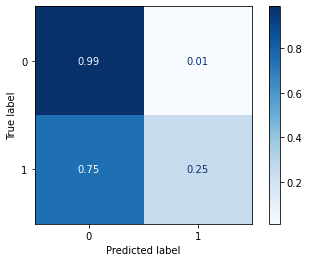

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

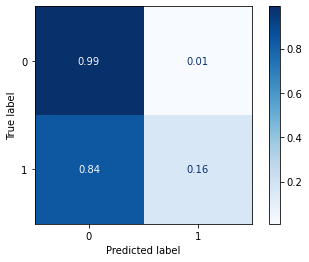

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

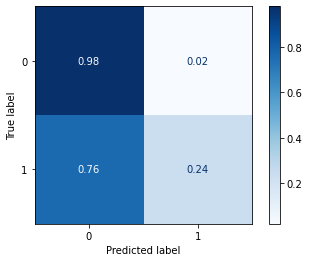

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

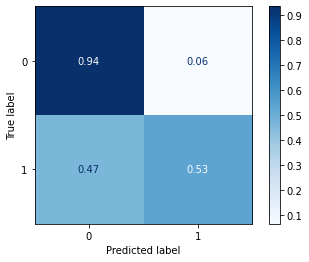

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2004 to 2007**

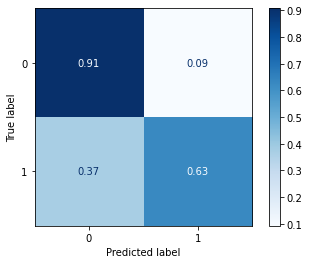

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

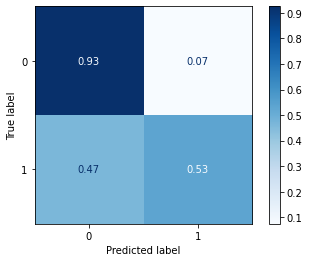

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

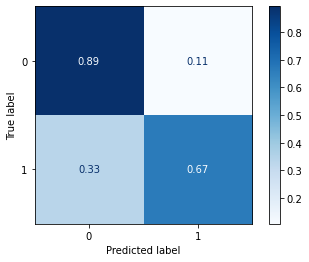

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2004 to 2007**

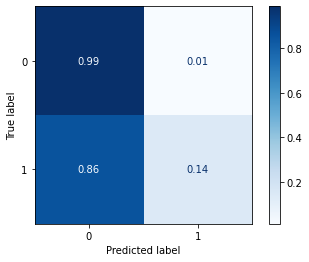

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

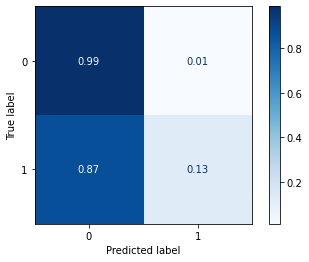

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

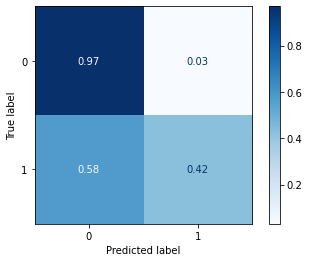

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2008 to 2011**

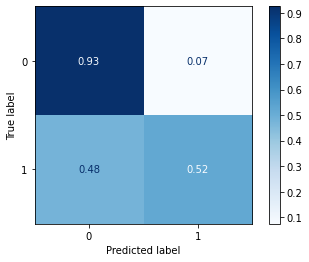

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

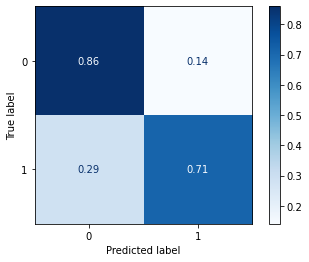

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2008 to 2011**

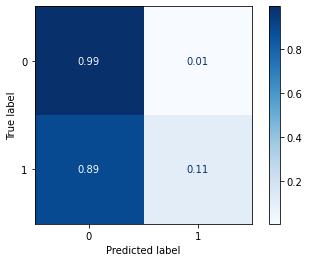

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

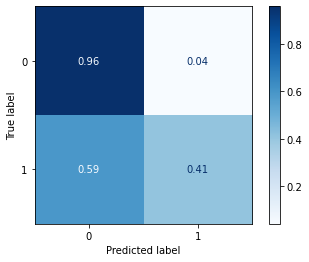

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2012 to 2015**

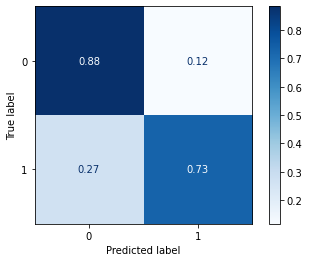

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2012 to 2015**

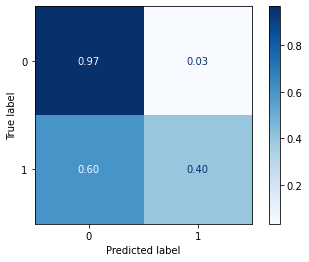

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

# **Fifth approach**

Approach with grouped years and without the columns `EC` and `HORMONIO`.

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

**SP**

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 93)

**Other states**

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 93)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'obito_geral',
             'obito_cancer', 'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec',
             'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

X_train = (53228, 64), X_test = (15329, 64)
y_train = (53228,), y_test = (15329,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

X_train = (70060, 64), X_test = (19267, 64)
y_train = (70060,), y_test = (19267,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

X_train = (97274, 64), X_test = (25886, 64)
y_train = (97274,), y_test = (25886,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

X_train = (115836, 64), X_test = (29854, 64)
y_train = (115836,), y_test = (29854,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2021, 
                                                                                                random_state=seed)

X_train = (40680, 64), X_test = (11961, 64)
y_train = (40680,), y_test = (11961,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

X_train = (3108, 64), X_test = (877, 64)
y_train = (3108,), y_test = (877,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (4648, 64), X_test = (1218, 64)
y_train = (4648,), y_test = (1218,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (5732, 64), X_test = (1463, 64)
y_train = (5732,), y_test = (1463,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (7310, 64), X_test = (1782, 64)
y_train = (7310,), y_test = (1782,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2020, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (3186, 64), X_test = (981, 64)
y_train = (3186,), y_test = (981,)


## **Training and validation of the models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because even after balancing the data the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:60_000_000, 1:1},
                                     criterion='entropy')
rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

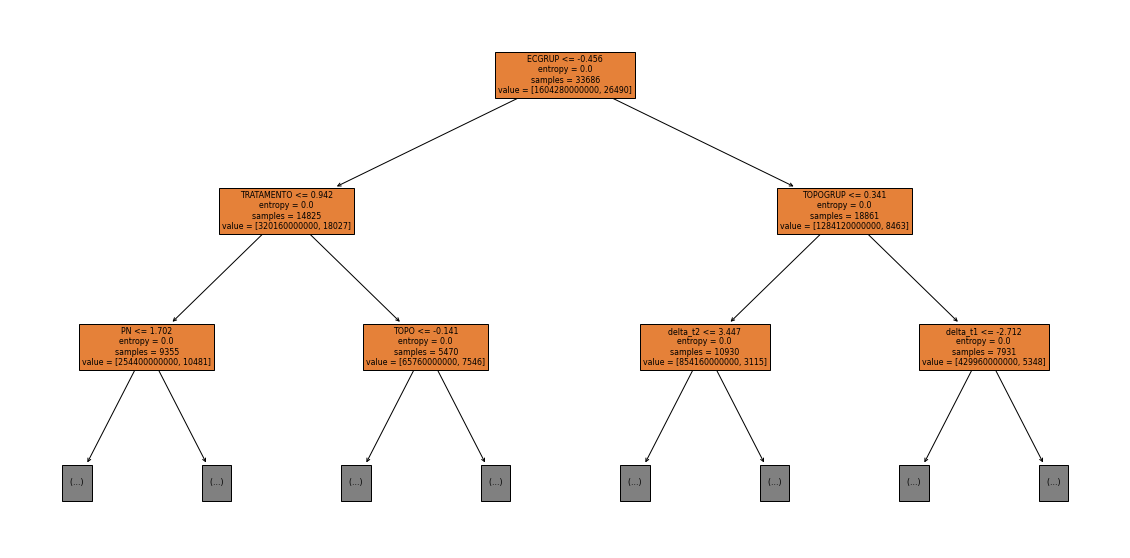

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

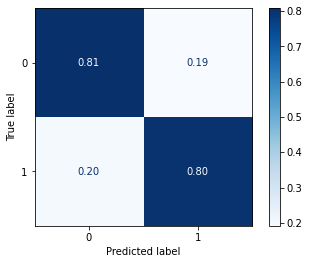

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2000 to 2003, shows a good performance, with 80% of accuracy.

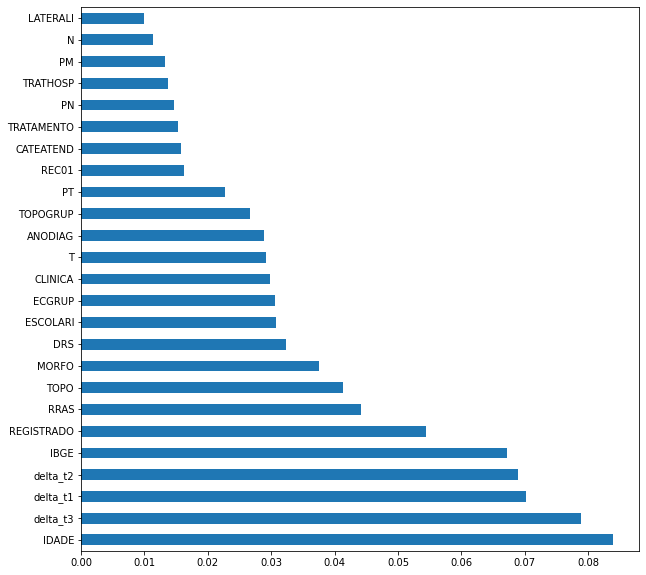

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `IDADE`, `delta_t3`, `delta_t1` and `delta_t2`.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:60_000_000, 1:1},
                                     criterion='entropy')
rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

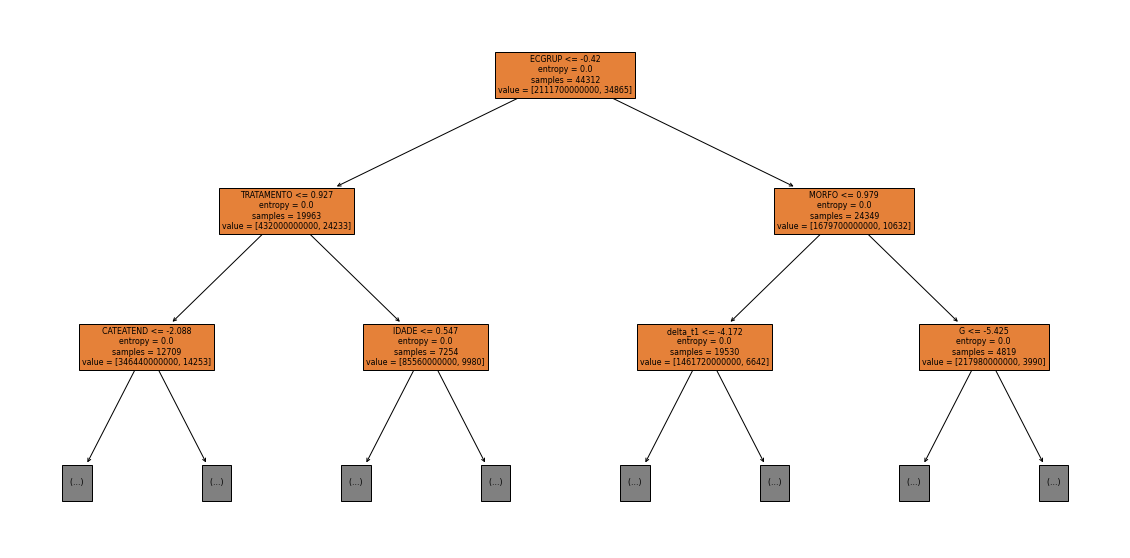

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

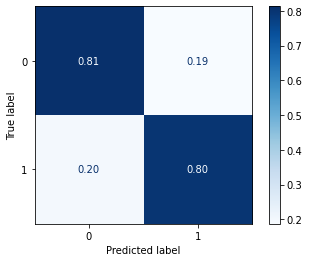

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

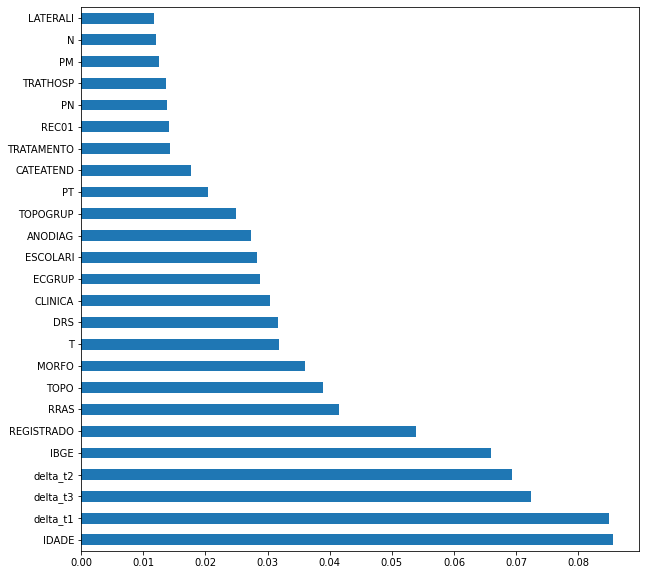

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:65_000_000, 1:1},
                                     criterion='entropy')
rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 65000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

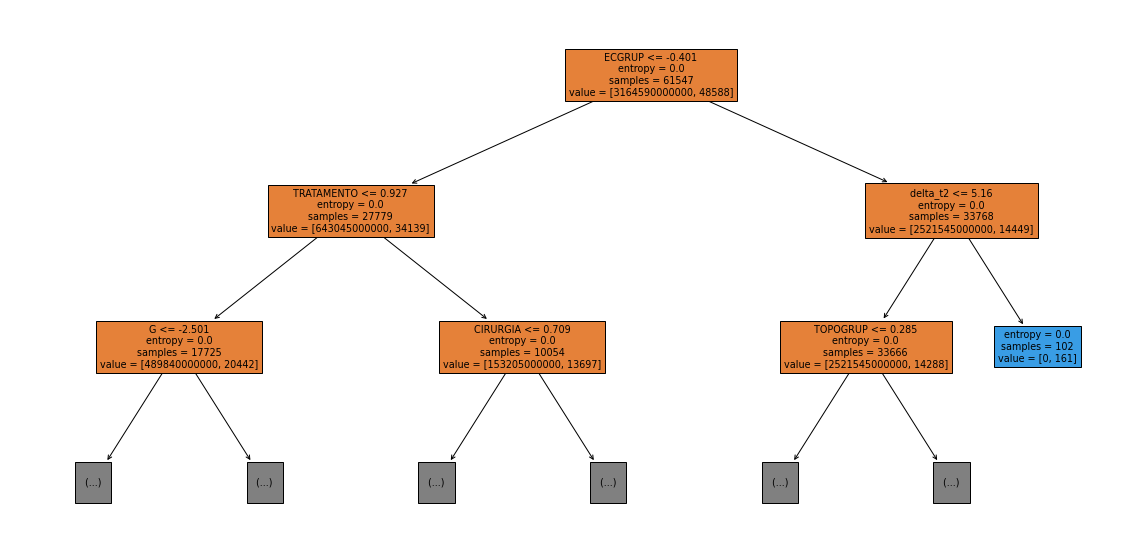

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

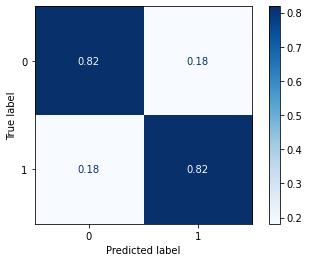

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuray.

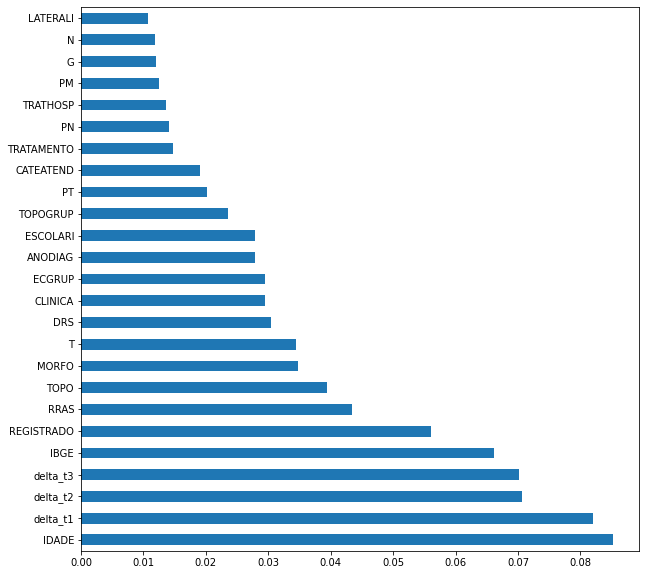

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `delta_t3`.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:65_000_000, 1:1},
                                     criterion='entropy')
rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 65000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

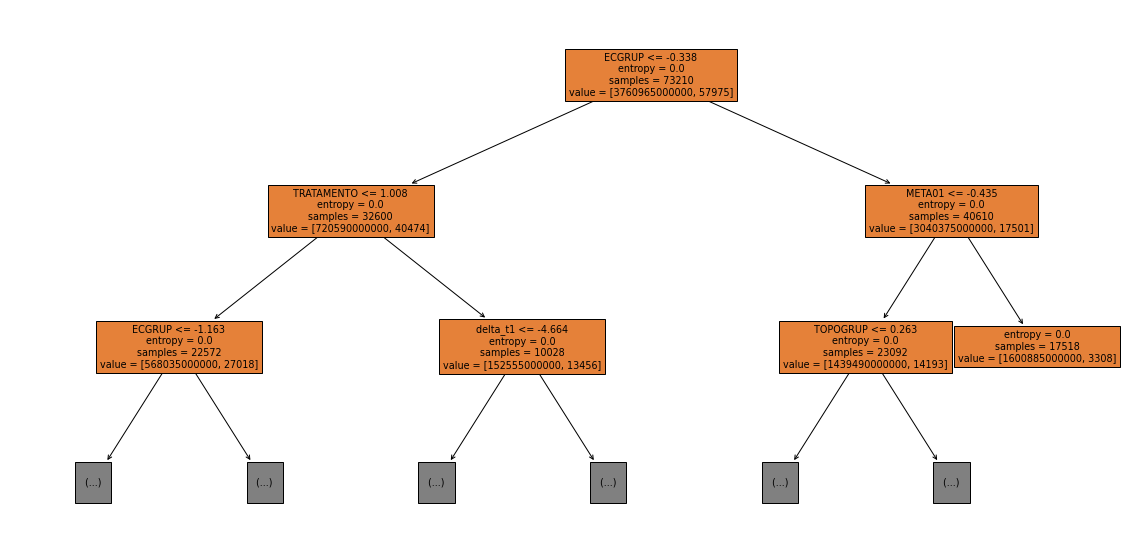

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

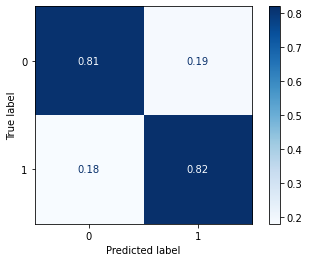

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

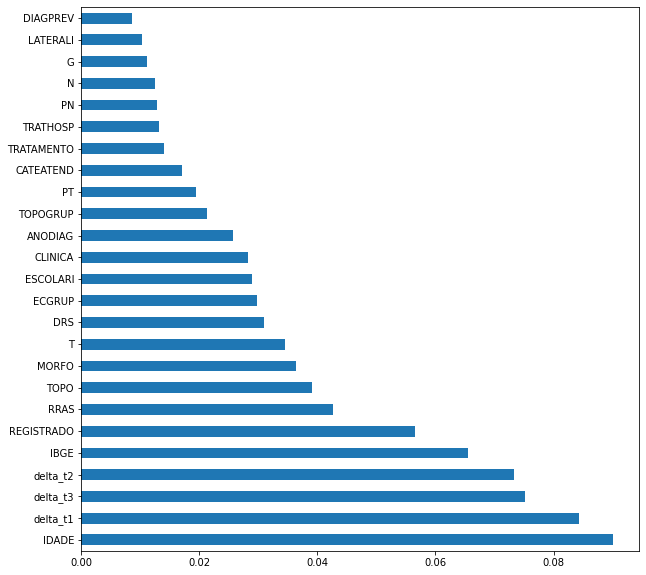

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:28_000_000, 1:1},
                                     criterion='entropy')
rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 28000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

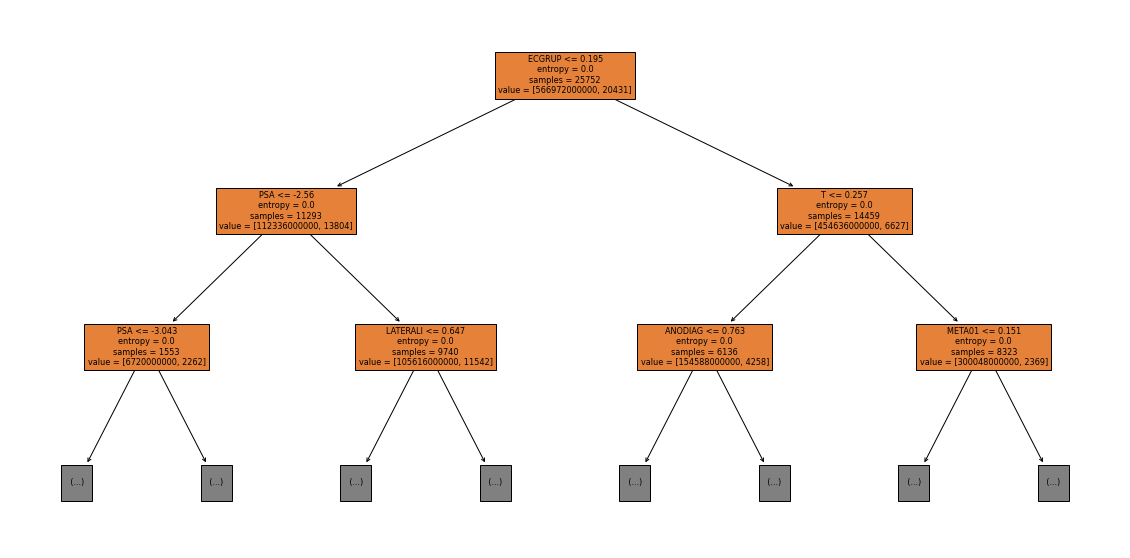

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

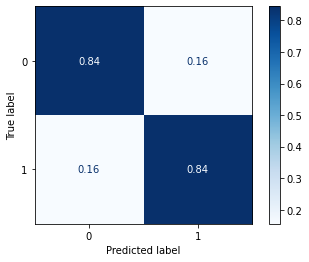

In [ ]:
plot_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model. The accuracy was 84%.

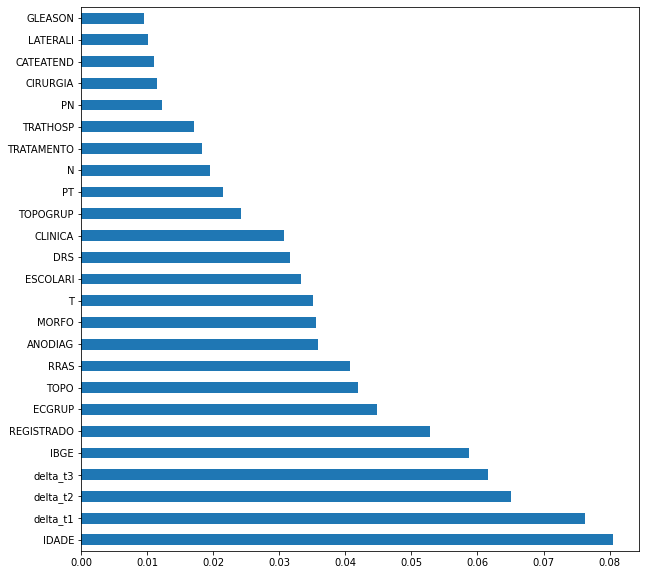

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `delta_t3`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:95_000_000, 1:1},
                                       criterion='entropy')
rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 95000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

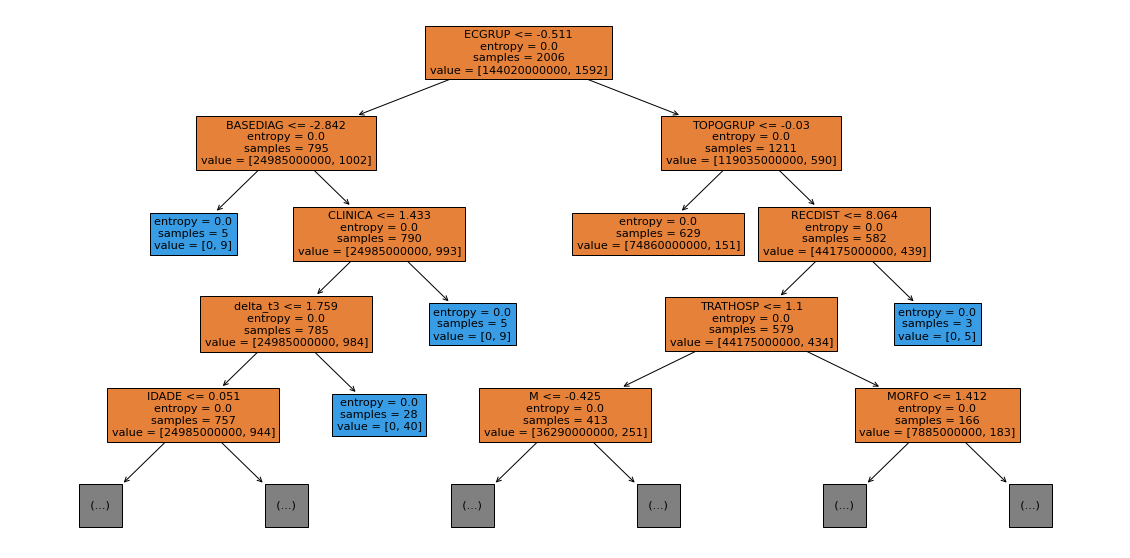

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 4)

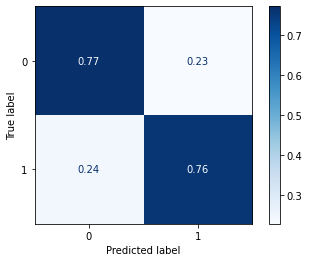

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix. The accuracy was 76%.

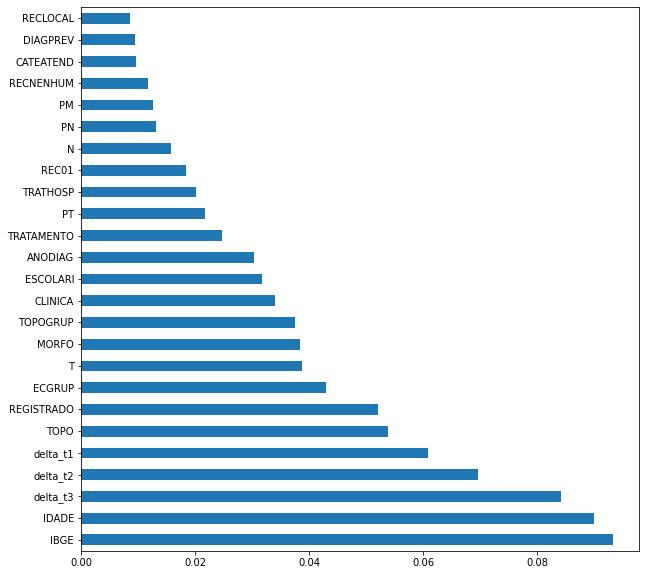

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `IBGE`, `IDADE`, `delta_t3` and `delta_t2`.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:61_000_000, 1:1},
                                       criterion='entropy')
rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 61000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

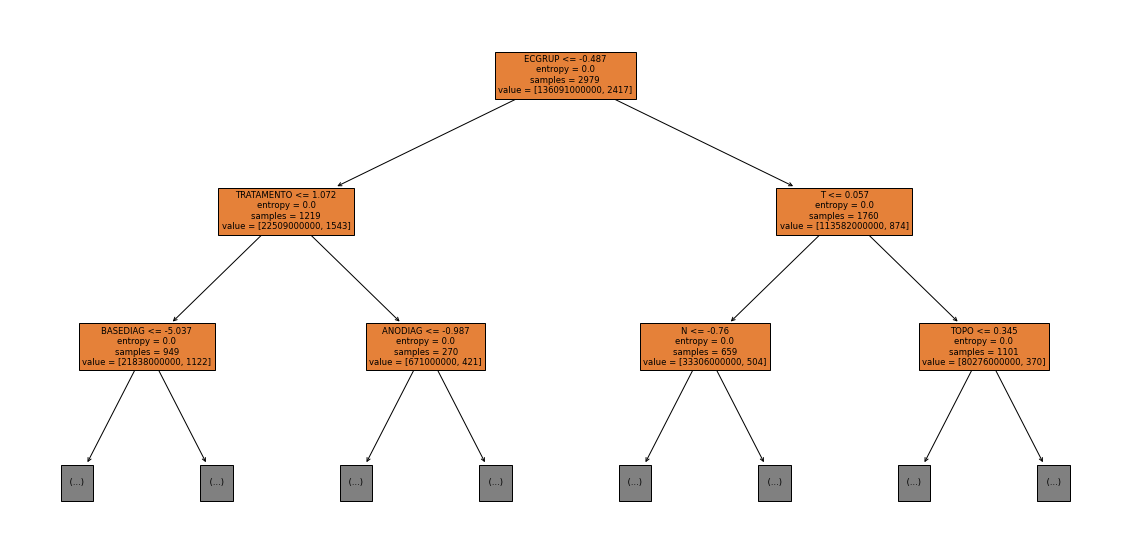

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

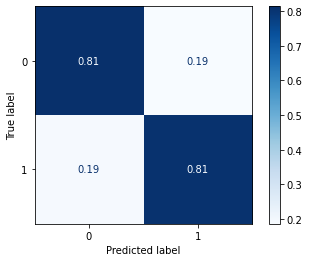

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 81% of accuracy.


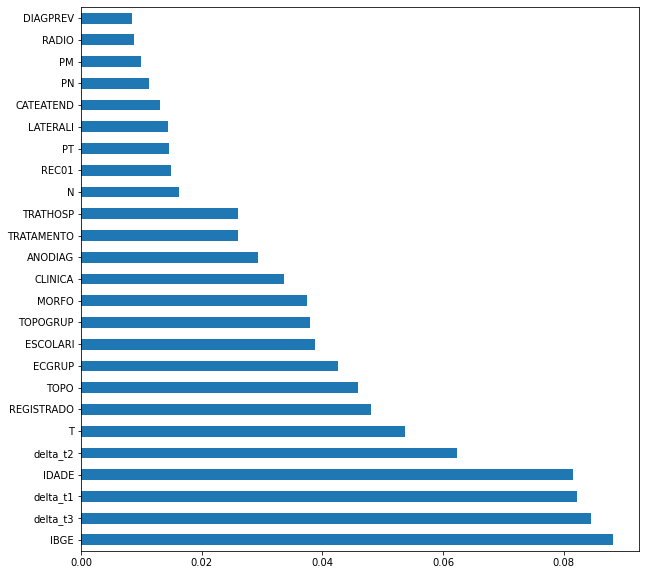

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `IBGE`, `delta_t3`, `delta_t1` and `IDADE`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:60_000_000, 1:1},
                                       criterion='entropy')
rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 60000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

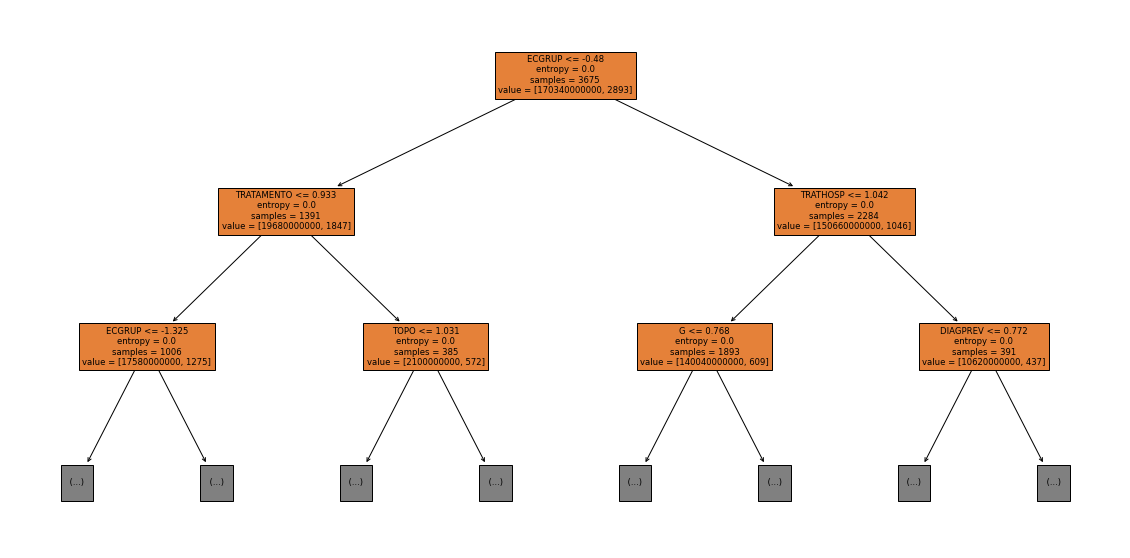

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

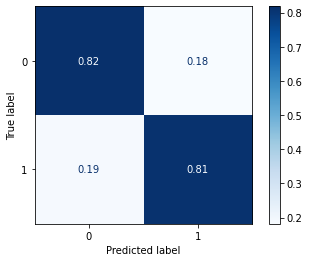

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, with 81% of accuracy.


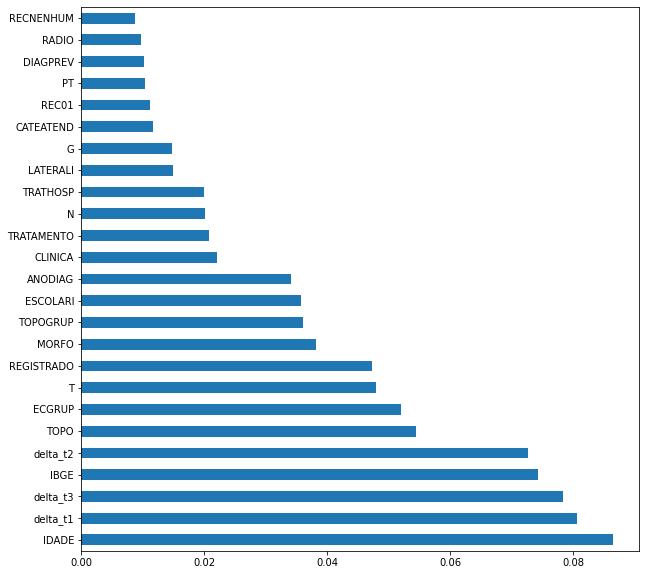

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:75_000_000, 1:1},
                                       criterion='entropy')
rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 75000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

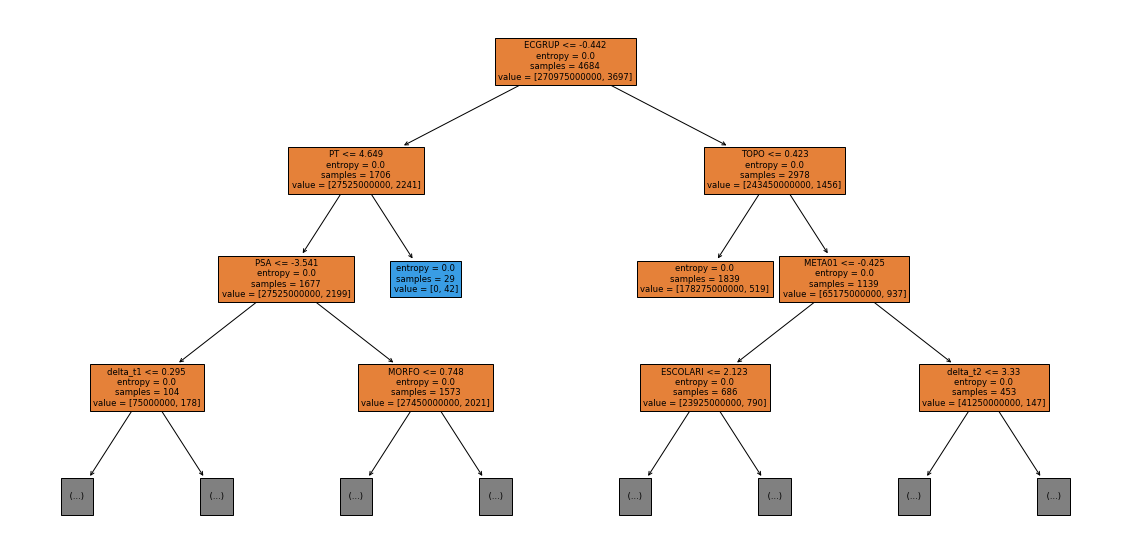

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 3)

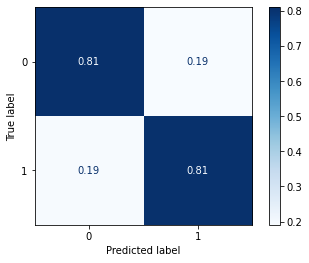

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 81% of accuracy.


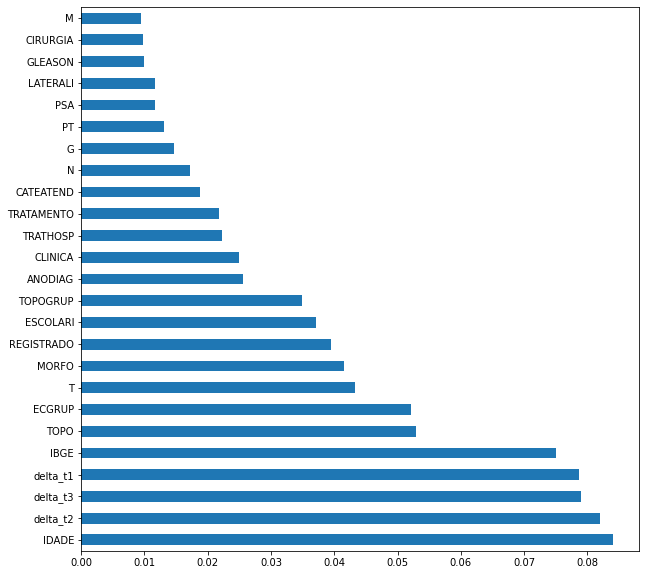

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `IDADE`, `delta_t2`, `delta_t3` and `delta_t1`.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:38_000_000, 1:1},
                                       criterion='entropy')
rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 38000000, 1: 1}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

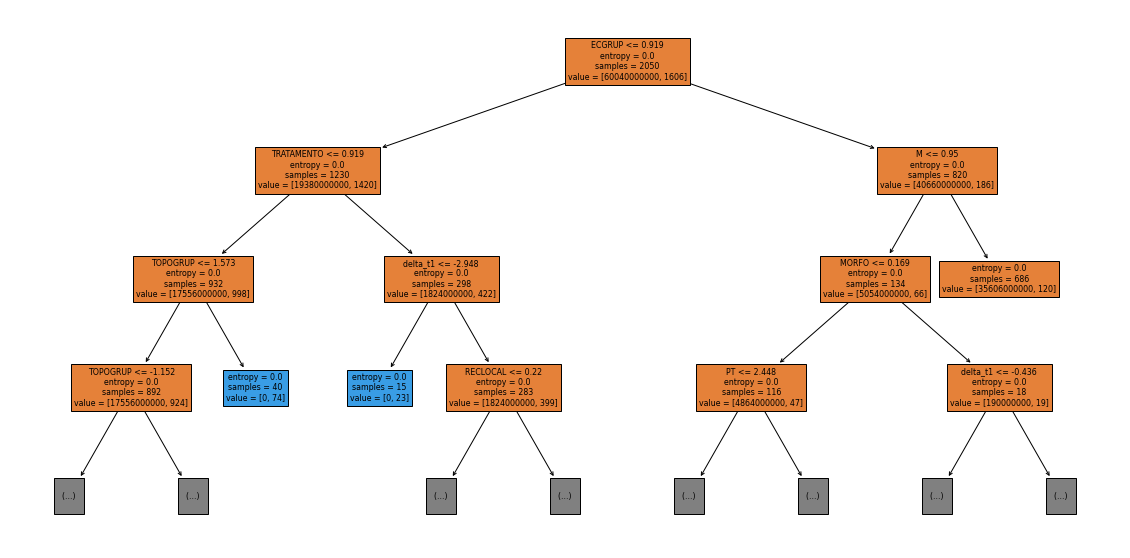

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 3)

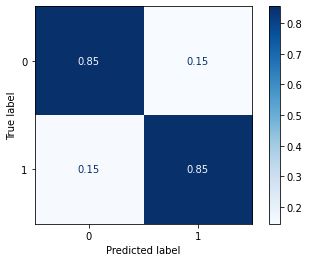

In [ ]:
plot_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance, the accuracy was 85%.




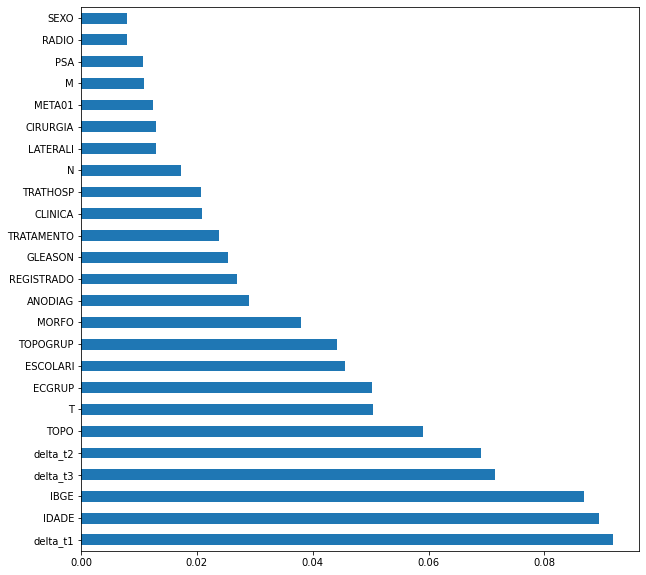

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `delta_t1`, `IDADE`, `IBGE` and `delta_t3`.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.53)
xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.53, seed=None,
              silent=None, subsample=1, verbosity=1)

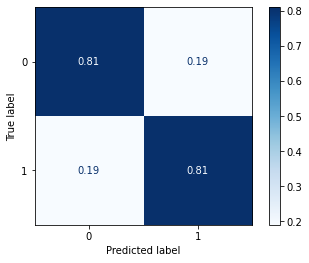

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, as well as the Random Forest model, here with 81% of accuracy.

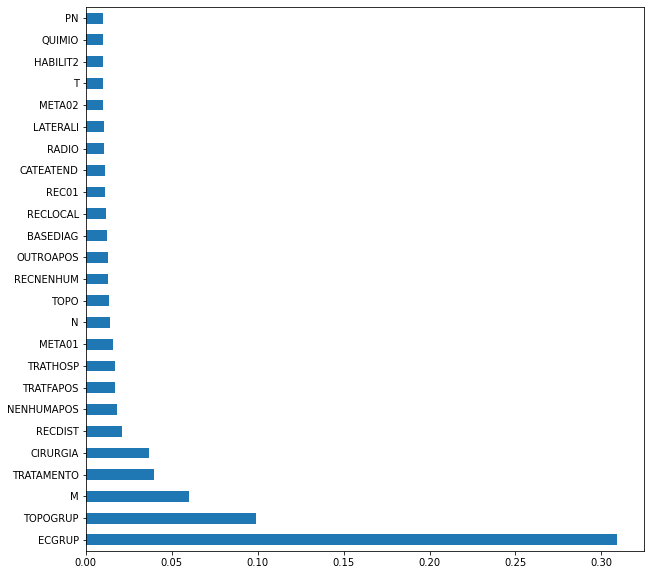

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `M` and `TRATAMENTO`.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.52)
xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.52, seed=None,
              silent=None, subsample=1, verbosity=1)

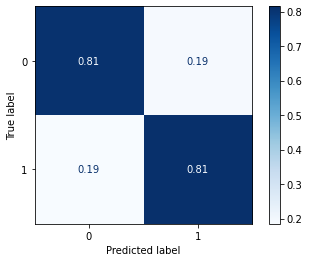

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.

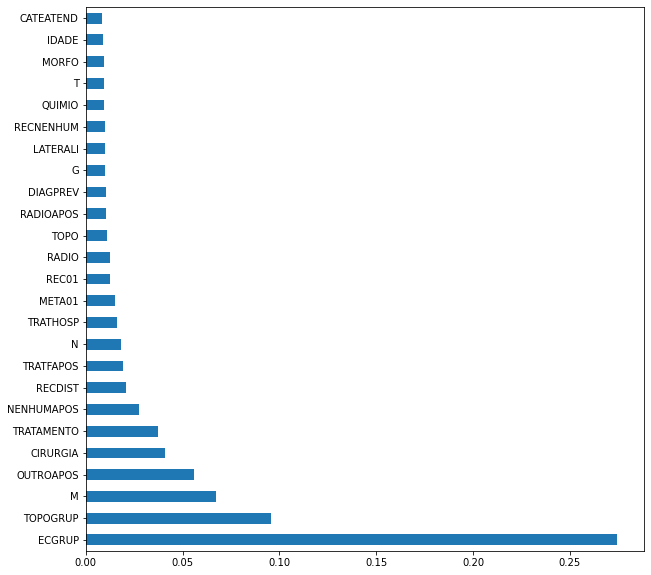

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `M` and `OUTROAPOS`.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.4)
xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4, seed=None,
              silent=None, subsample=1, verbosity=1)

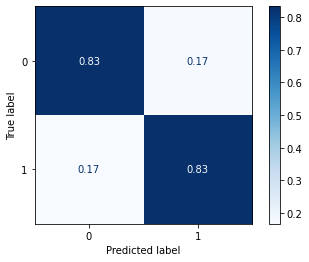

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

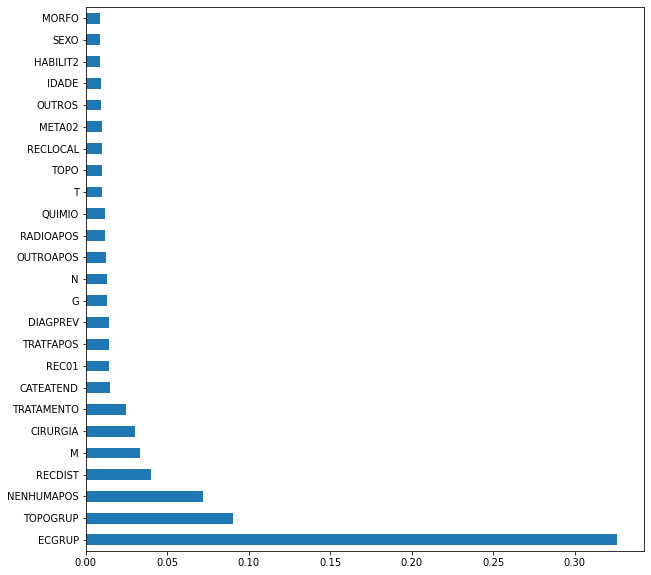

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, with some advantage, `TOPOGRUP`, `NENHUMAPOS` and `RECDIST`.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.37)
xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.37, seed=None,
              silent=None, subsample=1, verbosity=1)

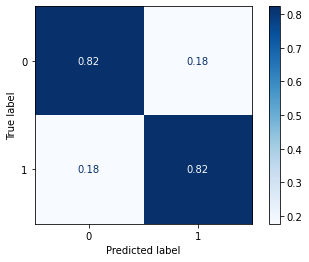

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

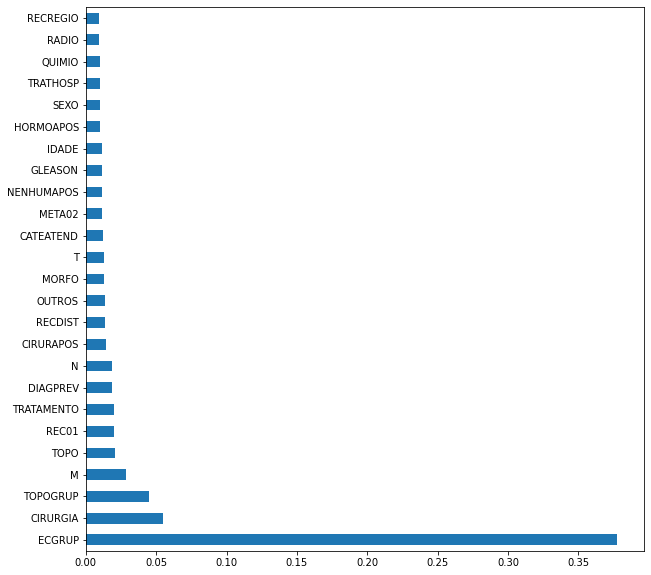

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, with a good advantage, `CIRURGIA`, `TOPOGRUP` and `M`.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=1.5)
xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5, seed=None,
              silent=None, subsample=1, verbosity=1)

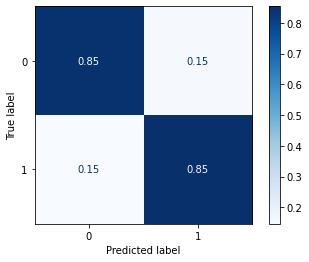

In [ ]:
plot_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.



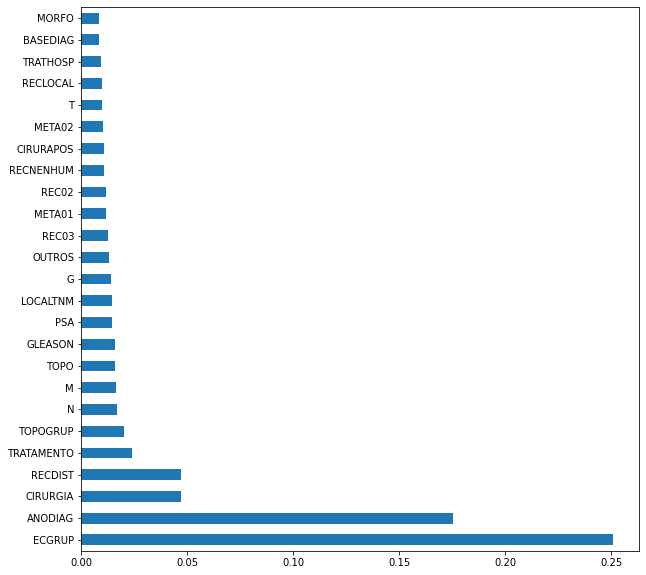

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `CIRURGIA` and `RECDIST`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                   scale_pos_weight=0.23)
xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.23, seed=None,
              silent=None, subsample=1, verbosity=1)

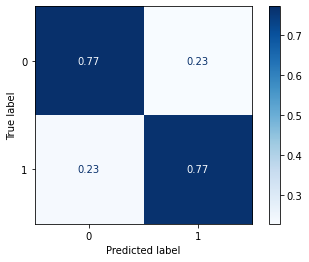

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 77% of accuracy.

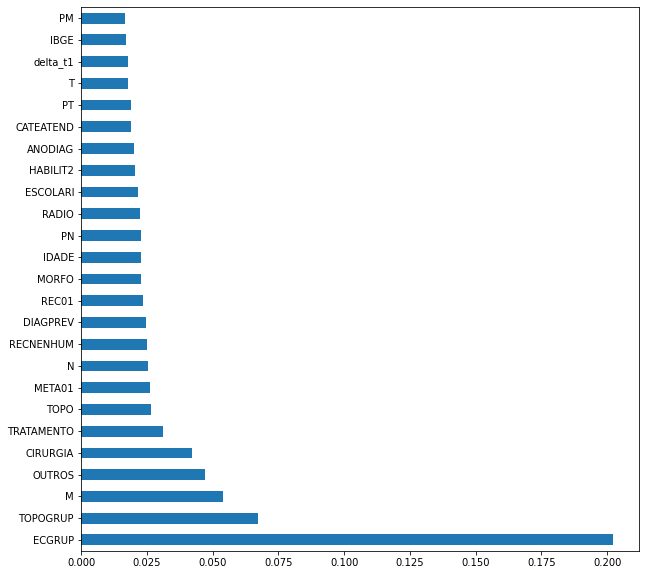

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> The two most important features in the model were `ECGRUP`, `TOPOGRUP`, `M` and `OUTROS`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.3,
                                   random_state=seed)
xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.3, seed=None,
              silent=None, subsample=1, verbosity=1)

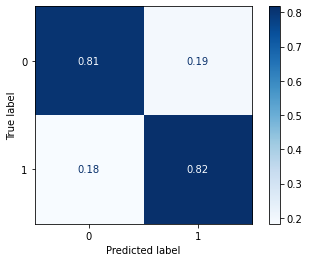

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

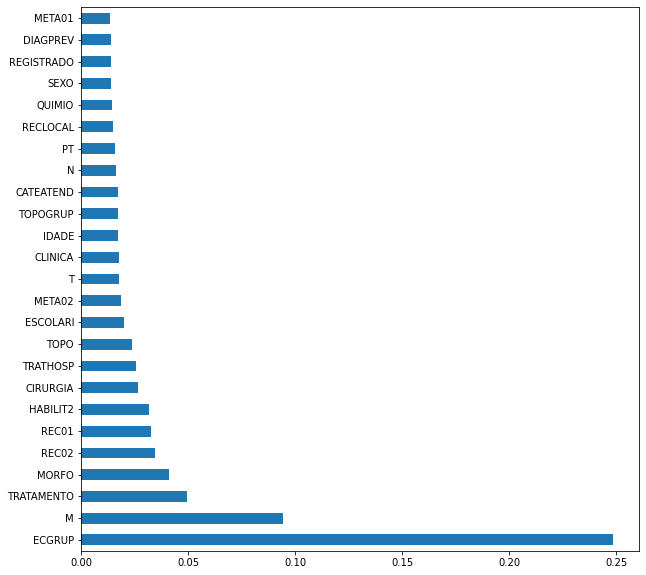

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> The two most important features in the model were `ECGRUP`, `M`, `TRATAMENTO` and `MORFO`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.25,
                                   random_state=seed)
xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25, seed=None,
              silent=None, subsample=1, verbosity=1)

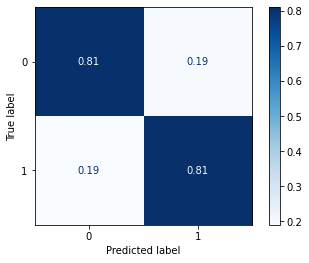

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, presented 81% of accuracy.

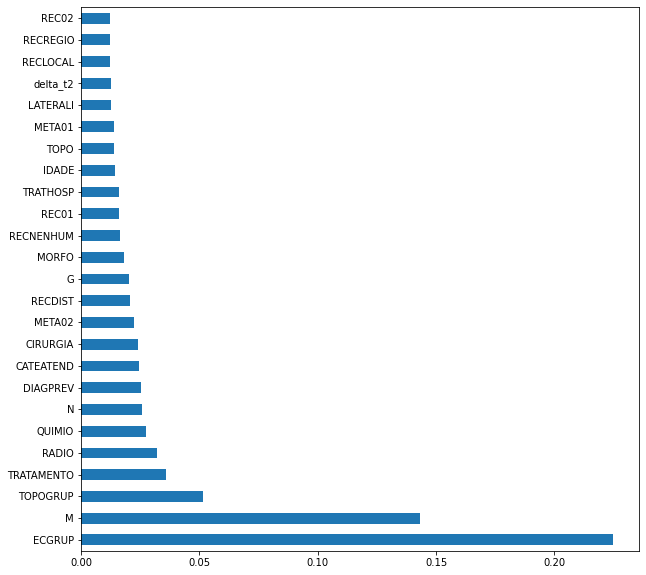

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `TRATAMENTO`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.168,
                                   random_state=seed)
xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.168, seed=None,
              silent=None, subsample=1, verbosity=1)

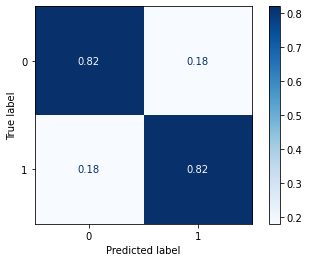

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, presented 82% of accuracy.

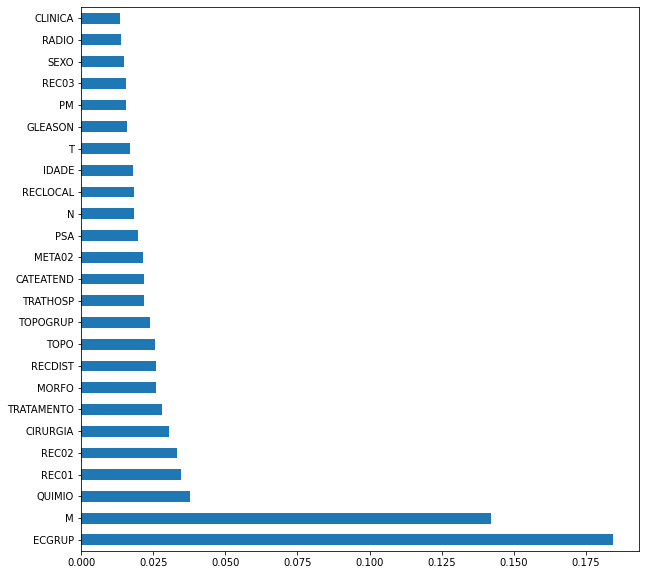

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `QUIMIO` and `REC01`.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1,
                                  random_state=seed)
xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

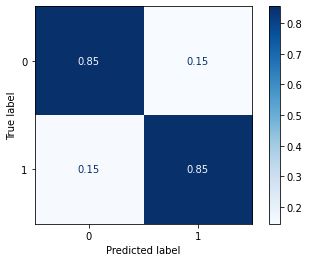

In [ ]:
plot_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows a good performance, with 85% of accuracy.

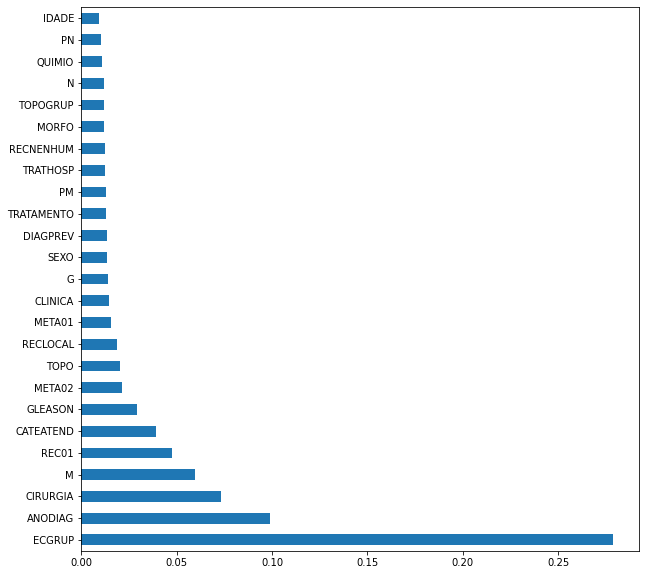

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, with a good advantage, `ANODIAG`, `CIRURGIA` and `M`.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

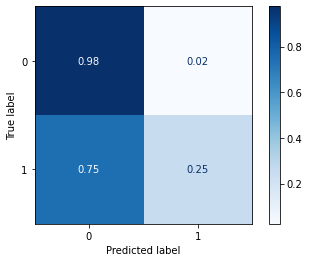

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

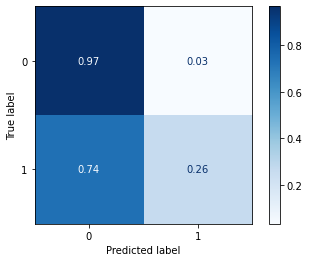

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

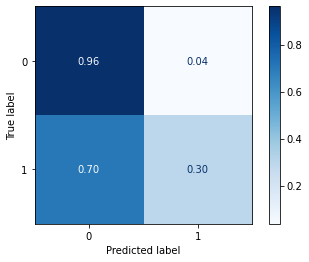

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

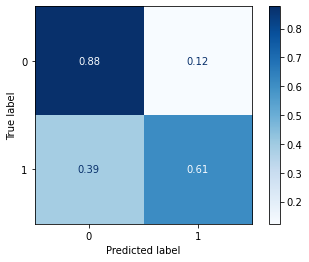

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2000 to 2003**

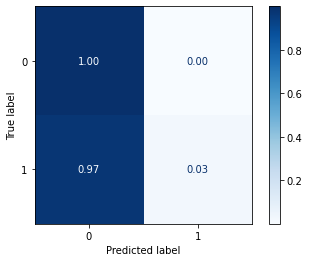

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

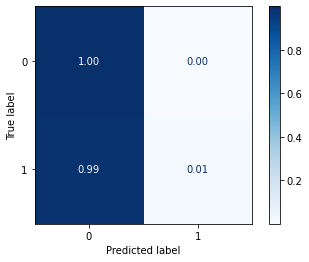

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

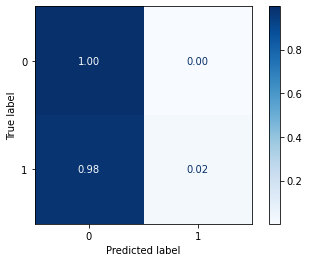

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

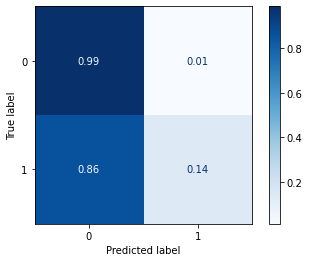

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2004 to 2007**

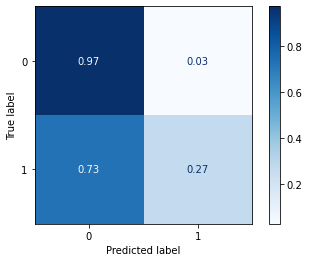

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

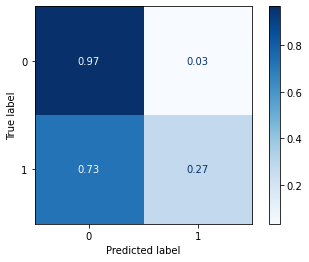

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

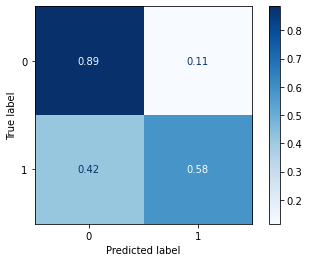

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2004 to 2007**

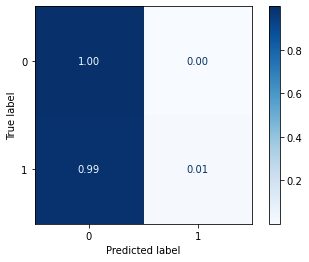

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

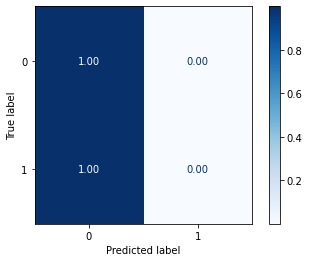

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

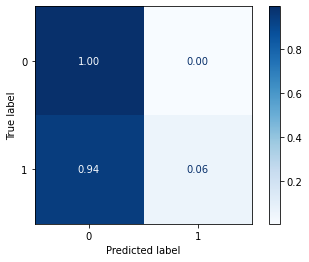

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2008 to 2011**

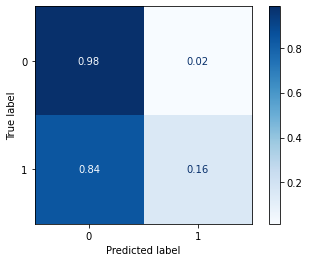

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

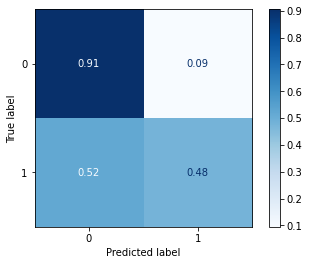

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2008 to 2011**

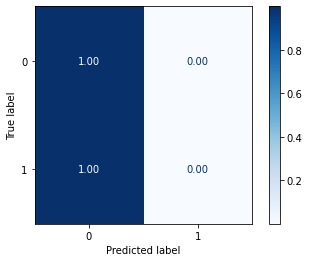

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

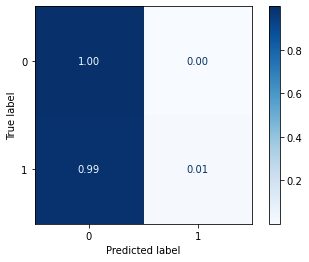

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2012 to 2015**

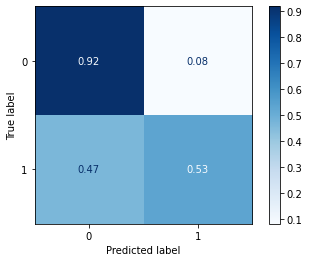

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2012 to 2015**

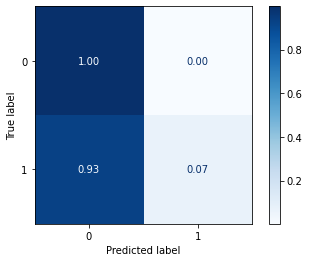

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2000 to 2003**

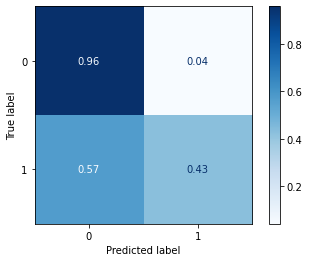

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

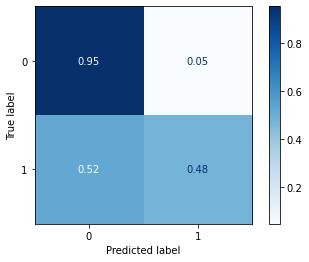

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

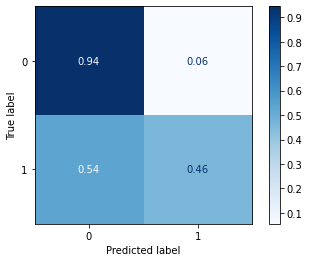

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

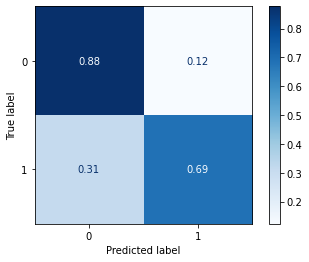

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2000 to 2003**

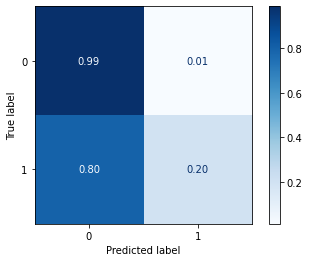

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

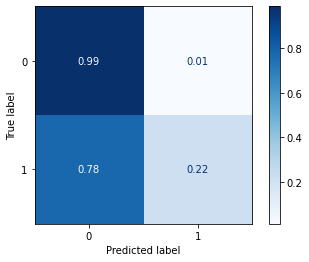

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

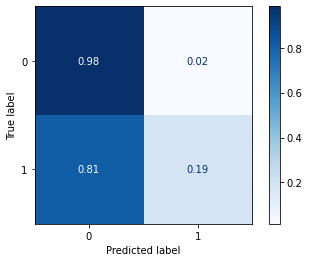

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

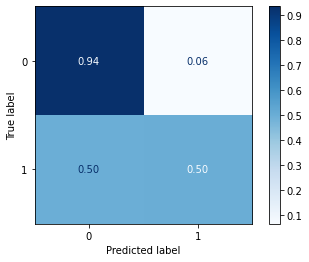

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2004 to 2007**

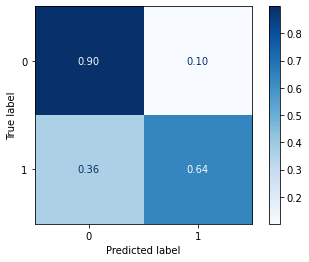

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

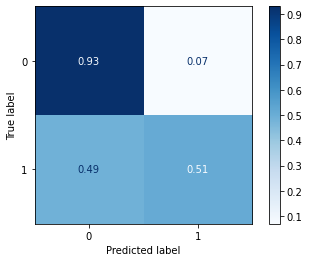

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

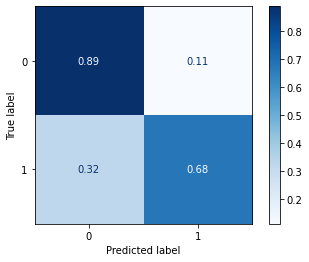

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2004 to 2007**

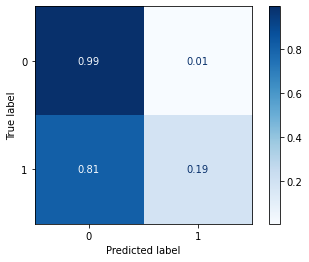

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

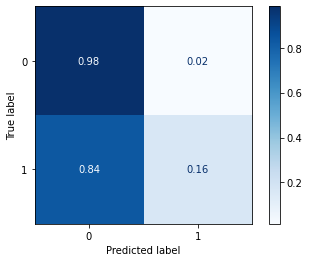

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

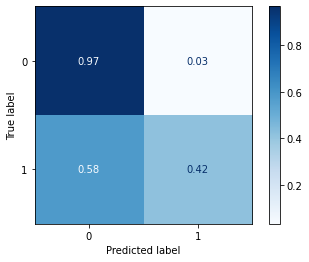

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2008 to 2011**

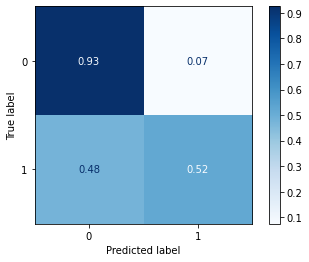

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

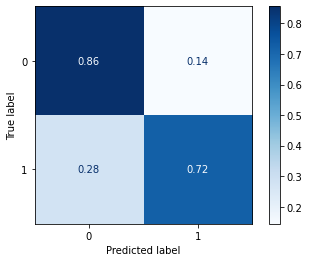

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2008 to 2011**

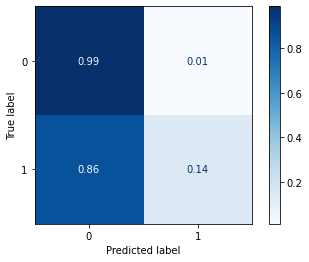

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

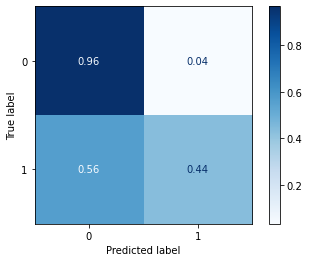

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2012 to 2015**

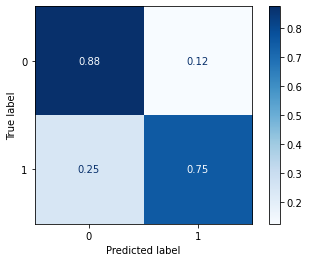

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2012 to 2015**

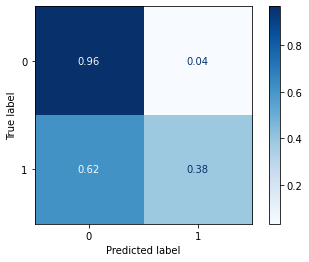

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()